In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


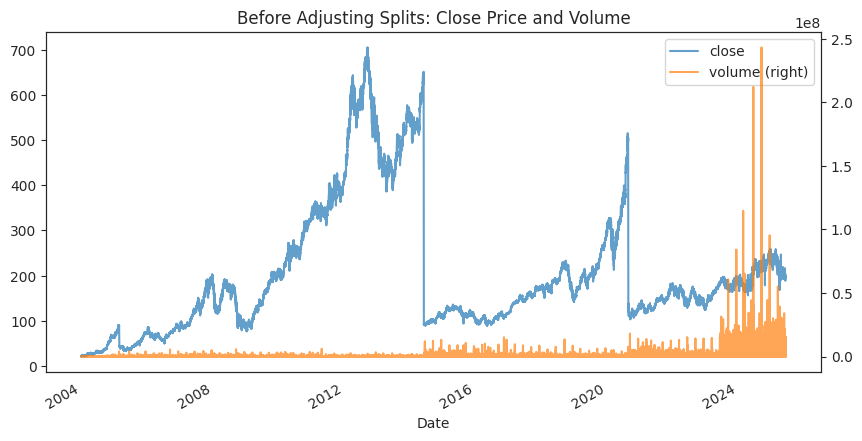

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


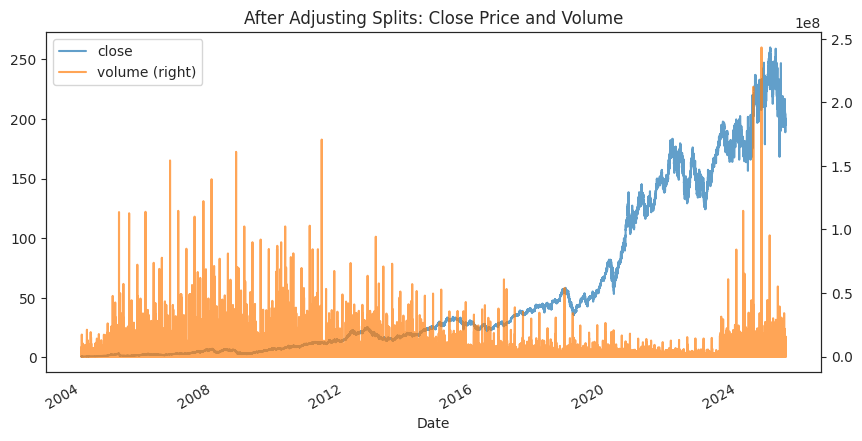

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 200
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',
        min_prof_thr             = min_prof_thr,
        max_down_prop            = max_down_prop,
        gain_tightening_factor   = gain_tightening_factor,
        merging_retracement_thr  = merging_retracement_thr,
        merging_time_gap_thr     = merging_time_gap_thr,
        pre_entry_decay          = pre_entry_decay,
        short_penal_decay        = short_penal_decay,
        trailing_stop_pct        = trailing_stop_pct,
        buy_threshold            = buy_threshold,
        top_percentile           = top_percentile
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.15, 0.35),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 1.5, 3.5),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.2),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.5, 2),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.02, 0.1),
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 0.5, 3),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.01, 0.05), 
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.2, 0.7),
        "top_percentile"          : trial.suggest_float("top_percentile", 0.5, 2.5)
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-08-22 10:59:49,815] A new study created in RDB with name: no-name-522b21f0-e139-4446-a8cc-c75491138745


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:02:38,352] Trial 0 finished with value: 0.6807705555555555 and parameters: {'min_prof_thr': 0.06748869345555078, 'max_down_prop': 0.20427211862626582, 'gain_tightening_factor': 3.1562251952943834, 'merging_retracement_thr': 0.1495364798557048, 'merging_time_gap_thr': 0.7538119690154099, 'pre_entry_decay': 0.030288675535889757, 'short_penal_decay': 2.621741681392993, 'trailing_stop_pct': 0.04557138962912011, 'buy_threshold': 0.27668567980877823, 'top_percentile': 1.278144900458105}. Best is trial 0 with value: 0.6807705555555555.


→ Total return across 5400 trading days: $3676.16
→ Avg daily return (all days)          : $0.6808
→ Total trades                          : 34655
→ Avg return per trade                  : $0.1061



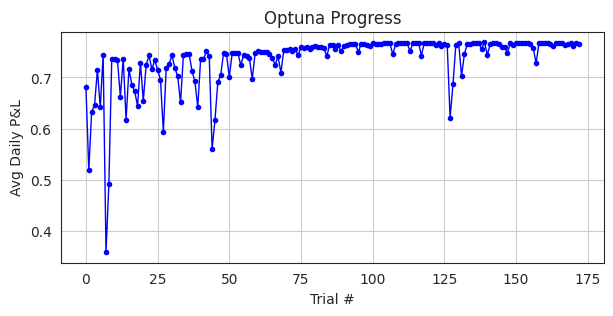

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:05:27,593] Trial 1 finished with value: 0.5185235185185185 and parameters: {'min_prof_thr': 0.04994647257397579, 'max_down_prop': 0.3400740768812994, 'gain_tightening_factor': 2.8399100173822465, 'merging_retracement_thr': 0.12654690741942776, 'merging_time_gap_thr': 0.8345962749666616, 'pre_entry_decay': 0.035407590114913776, 'short_penal_decay': 0.73727528292533, 'trailing_stop_pct': 0.04278107313826905, 'buy_threshold': 0.5641129008393442, 'top_percentile': 1.243091169511814}. Best is trial 0 with value: 0.6807705555555555.


→ Total return across 5400 trading days: $2800.03
→ Avg daily return (all days)          : $0.5185
→ Total trades                          : 17919
→ Avg return per trade                  : $0.1563

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:08:17,785] Trial 2 finished with value: 0.6324516666666666 and parameters: {'min_prof_thr': 0.07602800436023123, 'max_down_prop': 0.32314989958103973, 'gain_tightening_factor': 2.4039884883287224, 'merging_retracement_thr': 0.13377577794719014, 'merging_time_gap_thr': 0.5262470561246315, 'pre_entry_decay': 0.07708105241088109, 'short_penal_decay': 1.6117195829995712, 'trailing_stop_pct': 0.013791719771287968, 'buy_threshold': 0.22987307328272966, 'top_percentile': 1.6421860047178494}. Best is trial 0 with value: 0.6807705555555555.


→ Total return across 5400 trading days: $3415.24
→ Avg daily return (all days)          : $0.6325
→ Total trades                          : 76282
→ Avg return per trade                  : $0.0448

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:11:05,701] Trial 3 finished with value: 0.6459288888888888 and parameters: {'min_prof_thr': 0.08898882727773223, 'max_down_prop': 0.17802011370132959, 'gain_tightening_factor': 2.9235858220369666, 'merging_retracement_thr': 0.18097790643811137, 'merging_time_gap_thr': 1.199638772945303, 'pre_entry_decay': 0.051358137533989365, 'short_penal_decay': 1.8333188660254822, 'trailing_stop_pct': 0.02998027754269432, 'buy_threshold': 0.596049366839391, 'top_percentile': 2.4486359166333367}. Best is trial 0 with value: 0.6807705555555555.


→ Total return across 5400 trading days: $3488.02
→ Avg daily return (all days)          : $0.6459
→ Total trades                          : 26197
→ Avg return per trade                  : $0.1331

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:13:54,036] Trial 4 finished with value: 0.7146937037037037 and parameters: {'min_prof_thr': 0.05199366693332839, 'max_down_prop': 0.29635510859643355, 'gain_tightening_factor': 2.7001178554823864, 'merging_retracement_thr': 0.16404763295229802, 'merging_time_gap_thr': 0.9323135856457357, 'pre_entry_decay': 0.04972066522665239, 'short_penal_decay': 0.855888479053035, 'trailing_stop_pct': 0.02165380642197918, 'buy_threshold': 0.3819711874266616, 'top_percentile': 1.3125022298398956}. Best is trial 4 with value: 0.7146937037037037.


→ Total return across 5400 trading days: $3859.35
→ Avg daily return (all days)          : $0.7147
→ Total trades                          : 40558
→ Avg return per trade                  : $0.0952

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:16:45,581] Trial 5 finished with value: 0.6412531481481482 and parameters: {'min_prof_thr': 0.05340415109888549, 'max_down_prop': 0.16556717059712914, 'gain_tightening_factor': 1.5982982998930766, 'merging_retracement_thr': 0.1879005109008356, 'merging_time_gap_thr': 0.6977977897183208, 'pre_entry_decay': 0.09272127523957979, 'short_penal_decay': 1.8781035323419708, 'trailing_stop_pct': 0.03839831546342308, 'buy_threshold': 0.2873094620023914, 'top_percentile': 2.264885265927677}. Best is trial 4 with value: 0.7146937037037037.


→ Total return across 5400 trading days: $3462.77
→ Avg daily return (all days)          : $0.6413
→ Total trades                          : 68756
→ Avg return per trade                  : $0.0504

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:19:35,611] Trial 6 finished with value: 0.7448872222222221 and parameters: {'min_prof_thr': 0.04011199256590964, 'max_down_prop': 0.1924092744763789, 'gain_tightening_factor': 2.592909949270978, 'merging_retracement_thr': 0.18784295904012008, 'merging_time_gap_thr': 1.5861926380198403, 'pre_entry_decay': 0.06818963463597584, 'short_penal_decay': 1.5759127284188494, 'trailing_stop_pct': 0.037005409489117604, 'buy_threshold': 0.3353064296955347, 'top_percentile': 1.1331272096185052}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $4022.39
→ Avg daily return (all days)          : $0.7449
→ Total trades                          : 44274
→ Avg return per trade                  : $0.0909

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:22:23,762] Trial 7 finished with value: 0.35773222222222223 and parameters: {'min_prof_thr': 0.06623387093752506, 'max_down_prop': 0.3113807547079823, 'gain_tightening_factor': 1.5210341574276287, 'merging_retracement_thr': 0.13891215385748754, 'merging_time_gap_thr': 0.5019617126775218, 'pre_entry_decay': 0.09140140596153412, 'short_penal_decay': 1.9659980205159575, 'trailing_stop_pct': 0.04091842328728071, 'buy_threshold': 0.6826661558974967, 'top_percentile': 0.5746876476548262}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $1931.75
→ Avg daily return (all days)          : $0.3577
→ Total trades                          : 9947
→ Avg return per trade                  : $0.1942

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:25:12,006] Trial 8 finished with value: 0.4919031481481482 and parameters: {'min_prof_thr': 0.04730977947254589, 'max_down_prop': 0.2768067536512998, 'gain_tightening_factor': 2.577152010891217, 'merging_retracement_thr': 0.10835318017348246, 'merging_time_gap_thr': 1.2536545763557565, 'pre_entry_decay': 0.0542682247117464, 'short_penal_decay': 2.7006124810131698, 'trailing_stop_pct': 0.011950155493710408, 'buy_threshold': 0.4891764435322344, 'top_percentile': 0.6317661300281661}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $2656.28
→ Avg daily return (all days)          : $0.4919
→ Total trades                          : 16394
→ Avg return per trade                  : $0.1620

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:28:01,297] Trial 9 finished with value: 0.7351624074074073 and parameters: {'min_prof_thr': 0.0515084471603087, 'max_down_prop': 0.2269162975489566, 'gain_tightening_factor': 2.5740829711099007, 'merging_retracement_thr': 0.14645956103117908, 'merging_time_gap_thr': 1.7419894974368983, 'pre_entry_decay': 0.06974099509696917, 'short_penal_decay': 0.70412045074997, 'trailing_stop_pct': 0.021244144289098356, 'buy_threshold': 0.3965736701804836, 'top_percentile': 2.114362007068973}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3969.88
→ Avg daily return (all days)          : $0.7352
→ Total trades                          : 56597
→ Avg return per trade                  : $0.0701

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:30:52,429] Trial 10 finished with value: 0.7357611111111111 and parameters: {'min_prof_thr': 0.01955148894248809, 'max_down_prop': 0.24395911172454918, 'gain_tightening_factor': 2.101526041727954, 'merging_retracement_thr': 0.1959994155260933, 'merging_time_gap_thr': 1.9891513000895555, 'pre_entry_decay': 0.07025949175825141, 'short_penal_decay': 1.2782919783294098, 'trailing_stop_pct': 0.03326910632920868, 'buy_threshold': 0.3460495279132235, 'top_percentile': 0.8976859720278831}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3973.11
→ Avg daily return (all days)          : $0.7358
→ Total trades                          : 41255
→ Avg return per trade                  : $0.0963

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:33:43,796] Trial 11 finished with value: 0.7338042592592593 and parameters: {'min_prof_thr': 0.019755962456553186, 'max_down_prop': 0.2508898443430759, 'gain_tightening_factor': 2.095094657426699, 'merging_retracement_thr': 0.19661781666897638, 'merging_time_gap_thr': 1.9887439461188885, 'pre_entry_decay': 0.08005960320513367, 'short_penal_decay': 1.112648625763244, 'trailing_stop_pct': 0.03347971157389992, 'buy_threshold': 0.3492906481826608, 'top_percentile': 0.9423078661839157}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3962.54
→ Avg daily return (all days)          : $0.7338
→ Total trades                          : 45245
→ Avg return per trade                  : $0.0876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:36:39,260] Trial 12 finished with value: 0.662289074074074 and parameters: {'min_prof_thr': 0.019251761670223688, 'max_down_prop': 0.21592933463209696, 'gain_tightening_factor': 2.0572658035832556, 'merging_retracement_thr': 0.17102590186114072, 'merging_time_gap_thr': 1.5981523482804372, 'pre_entry_decay': 0.06814300759619542, 'short_penal_decay': 1.36337637926023, 'trailing_stop_pct': 0.030397849264121878, 'buy_threshold': 0.4348319835138329, 'top_percentile': 0.9199372568537156}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3576.36
→ Avg daily return (all days)          : $0.6623
→ Total trades                          : 29386
→ Avg return per trade                  : $0.1217

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:39:29,010] Trial 13 finished with value: 0.7367077777777777 and parameters: {'min_prof_thr': 0.03216832465739401, 'max_down_prop': 0.2549840593661107, 'gain_tightening_factor': 2.152152667061125, 'merging_retracement_thr': 0.19495815722611134, 'merging_time_gap_thr': 1.991219088491727, 'pre_entry_decay': 0.06625180720085011, 'short_penal_decay': 2.2477043213862142, 'trailing_stop_pct': 0.04839679114957121, 'buy_threshold': 0.32638544476961595, 'top_percentile': 1.6559125156853436}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3978.22
→ Avg daily return (all days)          : $0.7367
→ Total trades                          : 46456
→ Avg return per trade                  : $0.0856

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:42:22,699] Trial 14 finished with value: 0.6172907407407408 and parameters: {'min_prof_thr': 0.03259468408442404, 'max_down_prop': 0.19201589920325485, 'gain_tightening_factor': 3.4931496517716383, 'merging_retracement_thr': 0.16569519886435385, 'merging_time_gap_thr': 1.6271906636403686, 'pre_entry_decay': 0.0619967882012629, 'short_penal_decay': 2.3702628028338797, 'trailing_stop_pct': 0.04767545370235829, 'buy_threshold': 0.2098458744860399, 'top_percentile': 1.770705292645472}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3333.37
→ Avg daily return (all days)          : $0.6173
→ Total trades                          : 60083
→ Avg return per trade                  : $0.0555

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:45:13,813] Trial 15 finished with value: 0.7165096296296296 and parameters: {'min_prof_thr': 0.031715603659161776, 'max_down_prop': 0.26862256777781834, 'gain_tightening_factor': 2.338942794946688, 'merging_retracement_thr': 0.18030481060904896, 'merging_time_gap_thr': 1.3992148992419446, 'pre_entry_decay': 0.04663804656480832, 'short_penal_decay': 2.2068018002942003, 'trailing_stop_pct': 0.04992988789039751, 'buy_threshold': 0.30227084315178526, 'top_percentile': 1.90767833714773}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3869.15
→ Avg daily return (all days)          : $0.7165
→ Total trades                          : 45164
→ Avg return per trade                  : $0.0857

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:48:02,285] Trial 16 finished with value: 0.6858890740740742 and parameters: {'min_prof_thr': 0.035663791881690526, 'max_down_prop': 0.2366733296572961, 'gain_tightening_factor': 1.8695355101675264, 'merging_retracement_thr': 0.1995554985621758, 'merging_time_gap_thr': 1.7932438456030633, 'pre_entry_decay': 0.08019407849308129, 'short_penal_decay': 2.2573048837038887, 'trailing_stop_pct': 0.03904515180516652, 'buy_threshold': 0.48151064927156206, 'top_percentile': 1.492778407967104}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3703.80
→ Avg daily return (all days)          : $0.6859
→ Total trades                          : 31433
→ Avg return per trade                  : $0.1178

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:50:50,837] Trial 17 finished with value: 0.6727859259259259 and parameters: {'min_prof_thr': 0.038673768929694353, 'max_down_prop': 0.26642583049878765, 'gain_tightening_factor': 2.3339714952853265, 'merging_retracement_thr': 0.17497812396224982, 'merging_time_gap_thr': 1.3942521751001384, 'pre_entry_decay': 0.040669800587852856, 'short_penal_decay': 2.946613581107637, 'trailing_stop_pct': 0.025145457689869047, 'buy_threshold': 0.42698692038522523, 'top_percentile': 1.9621859299377484}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3633.04
→ Avg daily return (all days)          : $0.6728
→ Total trades                          : 30062
→ Avg return per trade                  : $0.1209

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:53:44,815] Trial 18 finished with value: 0.6443905555555556 and parameters: {'min_prof_thr': 0.010613850369399193, 'max_down_prop': 0.18688585194501864, 'gain_tightening_factor': 1.8242510025612453, 'merging_retracement_thr': 0.16158423313133335, 'merging_time_gap_thr': 1.8030759517068746, 'pre_entry_decay': 0.020716355139168176, 'short_penal_decay': 1.6481761616814925, 'trailing_stop_pct': 0.04441332105456162, 'buy_threshold': 0.3133281221341182, 'top_percentile': 1.505267729095766}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3479.71
→ Avg daily return (all days)          : $0.6444
→ Total trades                          : 30984
→ Avg return per trade                  : $0.1123

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:56:35,647] Trial 19 finished with value: 0.7288038888888888 and parameters: {'min_prof_thr': 0.04227104072806248, 'max_down_prop': 0.1618681262168562, 'gain_tightening_factor': 3.132953266551281, 'merging_retracement_thr': 0.18799150739502252, 'merging_time_gap_thr': 1.5120536135970932, 'pre_entry_decay': 0.05970975256452212, 'short_penal_decay': 2.091472800145332, 'trailing_stop_pct': 0.03634991805732509, 'buy_threshold': 0.2483712627521488, 'top_percentile': 1.1052257943310544}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3935.54
→ Avg daily return (all days)          : $0.7288
→ Total trades                          : 51390
→ Avg return per trade                  : $0.0766

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 11:59:20,158] Trial 20 finished with value: 0.6545262962962963 and parameters: {'min_prof_thr': 0.09799746115289334, 'max_down_prop': 0.21261027681844316, 'gain_tightening_factor': 2.2227838581620025, 'merging_retracement_thr': 0.10433783458444926, 'merging_time_gap_thr': 1.180296693114461, 'pre_entry_decay': 0.09709742744924352, 'short_penal_decay': 2.4478241137264103, 'trailing_stop_pct': 0.04847523299452025, 'buy_threshold': 0.5348679989264993, 'top_percentile': 1.5415288690343578}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3534.44
→ Avg daily return (all days)          : $0.6545
→ Total trades                          : 30076
→ Avg return per trade                  : $0.1175

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:02:10,720] Trial 21 finished with value: 0.7240531481481481 and parameters: {'min_prof_thr': 0.023751644586184624, 'max_down_prop': 0.24575069921038878, 'gain_tightening_factor': 1.9181926715834583, 'merging_retracement_thr': 0.18914035826939274, 'merging_time_gap_thr': 1.99643142630222, 'pre_entry_decay': 0.07134020653297808, 'short_penal_decay': 1.29884264970822, 'trailing_stop_pct': 0.0339908743935353, 'buy_threshold': 0.3481120101492446, 'top_percentile': 0.7870931244227852}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3909.89
→ Avg daily return (all days)          : $0.7241
→ Total trades                          : 38793
→ Avg return per trade                  : $0.1008

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:05:01,375] Trial 22 finished with value: 0.7430764814814814 and parameters: {'min_prof_thr': 0.02668513482299571, 'max_down_prop': 0.2896348899667933, 'gain_tightening_factor': 2.159822377601585, 'merging_retracement_thr': 0.19935693175145056, 'merging_time_gap_thr': 1.8971903905672736, 'pre_entry_decay': 0.06119966860920637, 'short_penal_decay': 1.473434838063049, 'trailing_stop_pct': 0.027846607086314454, 'buy_threshold': 0.3500666591722124, 'top_percentile': 1.080651995309613}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $4012.61
→ Avg daily return (all days)          : $0.7431
→ Total trades                          : 40808
→ Avg return per trade                  : $0.0983

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:07:51,294] Trial 23 finished with value: 0.7157898148148149 and parameters: {'min_prof_thr': 0.027656393447451112, 'max_down_prop': 0.2845594475249891, 'gain_tightening_factor': 2.2126386528078745, 'merging_retracement_thr': 0.18898599862940837, 'merging_time_gap_thr': 1.8570118058840994, 'pre_entry_decay': 0.061041502019626936, 'short_penal_decay': 1.521387066943578, 'trailing_stop_pct': 0.02634560101078784, 'buy_threshold': 0.3872951076531317, 'top_percentile': 1.0740090819353483}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3865.27
→ Avg daily return (all days)          : $0.7158
→ Total trades                          : 35753
→ Avg return per trade                  : $0.1081

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:10:44,234] Trial 24 finished with value: 0.7336585185185184 and parameters: {'min_prof_thr': 0.010347887305343813, 'max_down_prop': 0.29387765546302497, 'gain_tightening_factor': 2.441105657531385, 'merging_retracement_thr': 0.18045039943439264, 'merging_time_gap_thr': 1.6952769911847494, 'pre_entry_decay': 0.08674931608201066, 'short_penal_decay': 0.9704692296352779, 'trailing_stop_pct': 0.016406578845529148, 'buy_threshold': 0.32495911656175713, 'top_percentile': 1.3489614355792008}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3961.76
→ Avg daily return (all days)          : $0.7337
→ Total trades                          : 62570
→ Avg return per trade                  : $0.0633

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:13:34,901] Trial 25 finished with value: 0.715017037037037 and parameters: {'min_prof_thr': 0.042325792333231235, 'max_down_prop': 0.25869354363967356, 'gain_tightening_factor': 1.6768206114985005, 'merging_retracement_thr': 0.19828302818215013, 'merging_time_gap_thr': 1.8783629791565122, 'pre_entry_decay': 0.061688020801282856, 'short_penal_decay': 2.053404469041265, 'trailing_stop_pct': 0.027997056729876294, 'buy_threshold': 0.26189955047759794, 'top_percentile': 1.693602738067392}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3861.09
→ Avg daily return (all days)          : $0.7150
→ Total trades                          : 58156
→ Avg return per trade                  : $0.0664

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:16:23,899] Trial 26 finished with value: 0.6955753703703703 and parameters: {'min_prof_thr': 0.02797829158376186, 'max_down_prop': 0.3044386308427182, 'gain_tightening_factor': 2.778580094336677, 'merging_retracement_thr': 0.17466291539716114, 'merging_time_gap_thr': 1.5191070544987497, 'pre_entry_decay': 0.05556473399224482, 'short_penal_decay': 1.483984798173011, 'trailing_stop_pct': 0.021374273057762808, 'buy_threshold': 0.4033577197898587, 'top_percentile': 1.1066472721852874}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3756.11
→ Avg daily return (all days)          : $0.6956
→ Total trades                          : 33323
→ Avg return per trade                  : $0.1127

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:19:09,443] Trial 27 finished with value: 0.5934981481481482 and parameters: {'min_prof_thr': 0.06612837497169331, 'max_down_prop': 0.15236068624847968, 'gain_tightening_factor': 1.9485690755690523, 'merging_retracement_thr': 0.15628294691412278, 'merging_time_gap_thr': 1.8845138126515728, 'pre_entry_decay': 0.07493460377037688, 'short_penal_decay': 1.7285876042291293, 'trailing_stop_pct': 0.036256309144406126, 'buy_threshold': 0.468080824594895, 'top_percentile': 0.7464601356283053}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3204.89
→ Avg daily return (all days)          : $0.5935
→ Total trades                          : 22842
→ Avg return per trade                  : $0.1403

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:21:56,694] Trial 28 finished with value: 0.7192862962962963 and parameters: {'min_prof_thr': 0.06120103659470483, 'max_down_prop': 0.22976476533919815, 'gain_tightening_factor': 1.7243572458420016, 'merging_retracement_thr': 0.1906398212089749, 'merging_time_gap_thr': 1.6749988581878903, 'pre_entry_decay': 0.04476027267997972, 'short_penal_decay': 0.5014329587464856, 'trailing_stop_pct': 0.04152118484797618, 'buy_threshold': 0.35994880314983063, 'top_percentile': 1.3791264400503285}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3884.15
→ Avg daily return (all days)          : $0.7193
→ Total trades                          : 42301
→ Avg return per trade                  : $0.0918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:24:56,475] Trial 29 finished with value: 0.725596111111111 and parameters: {'min_prof_thr': 0.04177093876695766, 'max_down_prop': 0.19797007160392766, 'gain_tightening_factor': 2.9960888786658186, 'merging_retracement_thr': 0.18152672642767045, 'merging_time_gap_thr': 1.509578924073174, 'pre_entry_decay': 0.08459521015148379, 'short_penal_decay': 2.583234723037782, 'trailing_stop_pct': 0.04525882606763036, 'buy_threshold': 0.27944114980528445, 'top_percentile': 1.165906965515651}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3918.22
→ Avg daily return (all days)          : $0.7256
→ Total trades                          : 50813
→ Avg return per trade                  : $0.0771

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:28:04,242] Trial 30 finished with value: 0.7433364814814816 and parameters: {'min_prof_thr': 0.05992158692530904, 'max_down_prop': 0.3269154832947192, 'gain_tightening_factor': 2.621804411436147, 'merging_retracement_thr': 0.12192485353509644, 'merging_time_gap_thr': 1.9004833633247364, 'pre_entry_decay': 0.06524709072353764, 'short_penal_decay': 1.7916667026444515, 'trailing_stop_pct': 0.018025188201034065, 'buy_threshold': 0.32631529484300614, 'top_percentile': 1.8614225070452766}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $4014.02
→ Avg daily return (all days)          : $0.7433
→ Total trades                          : 56502
→ Avg return per trade                  : $0.0710

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:31:12,203] Trial 31 finished with value: 0.7187885185185185 and parameters: {'min_prof_thr': 0.05906548221403473, 'max_down_prop': 0.34678604281216485, 'gain_tightening_factor': 2.647490725803694, 'merging_retracement_thr': 0.11299012887634827, 'merging_time_gap_thr': 1.912551790135017, 'pre_entry_decay': 0.06606459586427547, 'short_penal_decay': 1.1261525490328255, 'trailing_stop_pct': 0.015204791494061136, 'buy_threshold': 0.31925219200111543, 'top_percentile': 1.919501907110317}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3881.46
→ Avg daily return (all days)          : $0.7188
→ Total trades                          : 63304
→ Avg return per trade                  : $0.0613

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:34:21,256] Trial 32 finished with value: 0.7021555555555555 and parameters: {'min_prof_thr': 0.07503817960917278, 'max_down_prop': 0.3325757924113664, 'gain_tightening_factor': 2.4957393841770994, 'merging_retracement_thr': 0.12677520480634077, 'merging_time_gap_thr': 1.770193272100224, 'pre_entry_decay': 0.06432488433119693, 'short_penal_decay': 1.788517433556814, 'trailing_stop_pct': 0.02319512803591202, 'buy_threshold': 0.2683024294372162, 'top_percentile': 1.8012902968873086}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3791.64
→ Avg daily return (all days)          : $0.7022
→ Total trades                          : 63354
→ Avg return per trade                  : $0.0598

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:37:37,580] Trial 33 finished with value: 0.6509877777777777 and parameters: {'min_prof_thr': 0.04600624164169643, 'max_down_prop': 0.31879098595576166, 'gain_tightening_factor': 2.195317557379632, 'merging_retracement_thr': 0.11670632449810658, 'merging_time_gap_thr': 1.8943389499659171, 'pre_entry_decay': 0.0749346351908827, 'short_penal_decay': 1.4727251394956493, 'trailing_stop_pct': 0.016982861460621456, 'buy_threshold': 0.23921460106368275, 'top_percentile': 1.631096439760033}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $3515.33
→ Avg daily return (all days)          : $0.6510
→ Total trades                          : 73951
→ Avg return per trade                  : $0.0475

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:40:52,754] Trial 34 finished with value: 0.7446846296296297 and parameters: {'min_prof_thr': 0.07674564047698701, 'max_down_prop': 0.3316278842311725, 'gain_tightening_factor': 2.772260946195197, 'merging_retracement_thr': 0.14671938590948574, 'merging_time_gap_thr': 1.7933907879141358, 'pre_entry_decay': 0.056747534845383515, 'short_penal_decay': 1.670650553277549, 'trailing_stop_pct': 0.018830242661012467, 'buy_threshold': 0.36860543586360905, 'top_percentile': 2.0807241929795905}. Best is trial 6 with value: 0.7448872222222221.


→ Total return across 5400 trading days: $4021.30
→ Avg daily return (all days)          : $0.7447
→ Total trades                          : 50098
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:44:01,070] Trial 35 finished with value: 0.7455381481481481 and parameters: {'min_prof_thr': 0.07954697366565866, 'max_down_prop': 0.3290563364364248, 'gain_tightening_factor': 2.9099560418732473, 'merging_retracement_thr': 0.14081256007671916, 'merging_time_gap_thr': 1.0382844212619529, 'pre_entry_decay': 0.05685187094096403, 'short_penal_decay': 1.6591602754542907, 'trailing_stop_pct': 0.018276658867309614, 'buy_threshold': 0.37549326378365055, 'top_percentile': 2.147846635769929}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $4025.91
→ Avg daily return (all days)          : $0.7455
→ Total trades                          : 50110
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:47:00,202] Trial 36 finished with value: 0.7453661111111112 and parameters: {'min_prof_thr': 0.07981567578086482, 'max_down_prop': 0.3308638375804509, 'gain_tightening_factor': 2.9058502445946908, 'merging_retracement_thr': 0.14395077907758305, 'merging_time_gap_thr': 0.9503406217135708, 'pre_entry_decay': 0.05538130787121878, 'short_penal_decay': 1.7167178573064426, 'trailing_stop_pct': 0.018959474270173714, 'buy_threshold': 0.4214687540805128, 'top_percentile': 2.4283120641598703}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $4024.98
→ Avg daily return (all days)          : $0.7454
→ Total trades                          : 45944
→ Avg return per trade                  : $0.0876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:49:46,673] Trial 37 finished with value: 0.7126903703703703 and parameters: {'min_prof_thr': 0.08285457295546733, 'max_down_prop': 0.3392858559878659, 'gain_tightening_factor': 2.91849401995234, 'merging_retracement_thr': 0.1448127825541715, 'merging_time_gap_thr': 1.0365104761371968, 'pre_entry_decay': 0.05489861257221176, 'short_penal_decay': 1.6377913851827475, 'trailing_stop_pct': 0.019514375176193026, 'buy_threshold': 0.5061219873927758, 'top_percentile': 2.476413697530239}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $3848.53
→ Avg daily return (all days)          : $0.7127
→ Total trades                          : 37391
→ Avg return per trade                  : $0.1029

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:52:34,316] Trial 38 finished with value: 0.6921033333333332 and parameters: {'min_prof_thr': 0.08076450922783833, 'max_down_prop': 0.3104445501218253, 'gain_tightening_factor': 3.2853117888685, 'merging_retracement_thr': 0.13510538478601547, 'merging_time_gap_thr': 0.7994465125477772, 'pre_entry_decay': 0.042238288616791034, 'short_penal_decay': 1.9323502242635835, 'trailing_stop_pct': 0.010840605555712274, 'buy_threshold': 0.4240484257626136, 'top_percentile': 2.322140650566177}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $3737.36
→ Avg daily return (all days)          : $0.6921
→ Total trades                          : 39998
→ Avg return per trade                  : $0.0934

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:55:24,597] Trial 39 finished with value: 0.6421044444444445 and parameters: {'min_prof_thr': 0.09477021354687656, 'max_down_prop': 0.3495618377415768, 'gain_tightening_factor': 2.7704652100691862, 'merging_retracement_thr': 0.1411899247780215, 'merging_time_gap_thr': 0.6546045271080145, 'pre_entry_decay': 0.03337180628631027, 'short_penal_decay': 1.623135637267821, 'trailing_stop_pct': 0.013059244464776014, 'buy_threshold': 0.4527509080681536, 'top_percentile': 2.11160156032589}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $3467.36
→ Avg daily return (all days)          : $0.6421
→ Total trades                          : 33061
→ Avg return per trade                  : $0.1049

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 12:58:15,601] Trial 40 finished with value: 0.735725925925926 and parameters: {'min_prof_thr': 0.07095756283945313, 'max_down_prop': 0.3180029866731169, 'gain_tightening_factor': 3.0377887967692287, 'merging_retracement_thr': 0.15008839085935874, 'merging_time_gap_thr': 0.966733097766554, 'pre_entry_decay': 0.04990973082681757, 'short_penal_decay': 1.9548637540977478, 'trailing_stop_pct': 0.019802379104895892, 'buy_threshold': 0.3756468449535332, 'top_percentile': 2.297066786829349}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $3972.92
→ Avg daily return (all days)          : $0.7357
→ Total trades                          : 46885
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:01:12,374] Trial 41 finished with value: 0.7357664814814815 and parameters: {'min_prof_thr': 0.0844519223217871, 'max_down_prop': 0.32942131325626384, 'gain_tightening_factor': 2.8751378630520823, 'merging_retracement_thr': 0.11957809729575065, 'merging_time_gap_thr': 1.0543305292968912, 'pre_entry_decay': 0.0508133468916738, 'short_penal_decay': 1.8151225635426524, 'trailing_stop_pct': 0.01874992400772475, 'buy_threshold': 0.4081866192356766, 'top_percentile': 2.1308328740301214}. Best is trial 35 with value: 0.7455381481481481.


→ Total return across 5400 trading days: $3973.14
→ Avg daily return (all days)          : $0.7358
→ Total trades                          : 43459
→ Avg return per trade                  : $0.0914

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:04:04,262] Trial 42 finished with value: 0.7508237037037038 and parameters: {'min_prof_thr': 0.09059442661617417, 'max_down_prop': 0.3294534581261931, 'gain_tightening_factor': 2.684481119335646, 'merging_retracement_thr': 0.12827894510210314, 'merging_time_gap_thr': 0.902755561933019, 'pre_entry_decay': 0.05587343966652637, 'short_penal_decay': 2.057247905790382, 'trailing_stop_pct': 0.02371369471791541, 'buy_threshold': 0.3740207468863792, 'top_percentile': 2.2144320451969066}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4054.45
→ Avg daily return (all days)          : $0.7508
→ Total trades                          : 48055
→ Avg return per trade                  : $0.0844

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:06:58,223] Trial 43 finished with value: 0.7421129629629629 and parameters: {'min_prof_thr': 0.09083183123308301, 'max_down_prop': 0.30372924958773617, 'gain_tightening_factor': 2.7529022349841115, 'merging_retracement_thr': 0.12951472430510041, 'merging_time_gap_thr': 0.878075760814204, 'pre_entry_decay': 0.05706180172517555, 'short_penal_decay': 2.112029621279645, 'trailing_stop_pct': 0.015567178404172804, 'buy_threshold': 0.36836394708234627, 'top_percentile': 2.0252017855250863}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4007.41
→ Avg daily return (all days)          : $0.7421
→ Total trades                          : 48193
→ Avg return per trade                  : $0.0832

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:10:09,598] Trial 44 finished with value: 0.5593324074074074 and parameters: {'min_prof_thr': 0.08873946589831228, 'max_down_prop': 0.33606202881503633, 'gain_tightening_factor': 3.24132532403344, 'merging_retracement_thr': 0.15053266786525402, 'merging_time_gap_thr': 1.0832207501802893, 'pre_entry_decay': 0.05204969970422558, 'short_penal_decay': 1.1712637197971705, 'trailing_stop_pct': 0.023696956923641783, 'buy_threshold': 0.691851002422587, 'top_percentile': 2.1954814625307977}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3020.39
→ Avg daily return (all days)          : $0.5593
→ Total trades                          : 21206
→ Avg return per trade                  : $0.1424

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:13:08,340] Trial 45 finished with value: 0.6166022222222223 and parameters: {'min_prof_thr': 0.07739523919723929, 'max_down_prop': 0.3195626179978071, 'gain_tightening_factor': 2.9974512474503348, 'merging_retracement_thr': 0.13359607625482245, 'merging_time_gap_thr': 0.9393752724038376, 'pre_entry_decay': 0.05649381467611436, 'short_penal_decay': 1.3957502420757435, 'trailing_stop_pct': 0.01426975912406585, 'buy_threshold': 0.6456131306149503, 'top_percentile': 2.4093459860380086}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3329.65
→ Avg daily return (all days)          : $0.6166
→ Total trades                          : 26523
→ Avg return per trade                  : $0.1255

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:16:02,006] Trial 46 finished with value: 0.6914924074074075 and parameters: {'min_prof_thr': 0.07079285316617225, 'max_down_prop': 0.34486666042496, 'gain_tightening_factor': 2.6964132934205716, 'merging_retracement_thr': 0.15693544642715038, 'merging_time_gap_thr': 0.7012152541992211, 'pre_entry_decay': 0.037896002190266814, 'short_penal_decay': 1.7319370461319046, 'trailing_stop_pct': 0.023075953906843392, 'buy_threshold': 0.45516862529300006, 'top_percentile': 2.3796294804316607}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3734.06
→ Avg daily return (all days)          : $0.6915
→ Total trades                          : 35094
→ Avg return per trade                  : $0.1064

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:18:56,318] Trial 47 finished with value: 0.7042792592592592 and parameters: {'min_prof_thr': 0.08770793216173284, 'max_down_prop': 0.3048045853979574, 'gain_tightening_factor': 2.8334104164742833, 'merging_retracement_thr': 0.13885703240545952, 'merging_time_gap_thr': 1.1806403113261221, 'pre_entry_decay': 0.045611202315813955, 'short_penal_decay': 1.8838638160481493, 'trailing_stop_pct': 0.031613693972861324, 'buy_threshold': 0.2957719506881573, 'top_percentile': 2.212082886622907}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3803.11
→ Avg daily return (all days)          : $0.7043
→ Total trades                          : 52920
→ Avg return per trade                  : $0.0719

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:21:51,605] Trial 48 finished with value: 0.7479362962962962 and parameters: {'min_prof_thr': 0.09374840678717535, 'max_down_prop': 0.32586150432438343, 'gain_tightening_factor': 2.524194817762442, 'merging_retracement_thr': 0.14539319480983293, 'merging_time_gap_thr': 1.3467432024254182, 'pre_entry_decay': 0.05835862534509903, 'short_penal_decay': 1.6028202751271086, 'trailing_stop_pct': 0.025328847321807794, 'buy_threshold': 0.41444509931095896, 'top_percentile': 2.020102799737921}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4038.86
→ Avg daily return (all days)          : $0.7479
→ Total trades                          : 43985
→ Avg return per trade                  : $0.0918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:24:45,123] Trial 49 finished with value: 0.7462118518518518 and parameters: {'min_prof_thr': 0.0932379554519236, 'max_down_prop': 0.1733493590255558, 'gain_tightening_factor': 2.5442613555338225, 'merging_retracement_thr': 0.1548372485625078, 'merging_time_gap_thr': 1.2742472211666318, 'pre_entry_decay': 0.07102575975197979, 'short_penal_decay': 1.5502129193501282, 'trailing_stop_pct': 0.028472214160594457, 'buy_threshold': 0.4145715984348149, 'top_percentile': 2.2102690832176584}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4029.54
→ Avg daily return (all days)          : $0.7462
→ Total trades                          : 47896
→ Avg return per trade                  : $0.0841

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $3784.78
→ Avg daily return (all days)          : $0.7009
→ Total trades                          : 35089
→ Avg return per trade                  : $0.1079



[I 2025-08-22 13:27:46,843] Trial 50 finished with value: 0.7008851851851853 and parameters: {'min_prof_thr': 0.09347251357759745, 'max_down_prop': 0.1723304529347759, 'gain_tightening_factor': 2.347893279455384, 'merging_retracement_thr': 0.15492413912078246, 'merging_time_gap_thr': 1.2817325386786145, 'pre_entry_decay': 0.05268673115805371, 'short_penal_decay': 1.3427885895146825, 'trailing_stop_pct': 0.025498298481483873, 'buy_threshold': 0.49813527768965277, 'top_percentile': 2.2554398503231776}. Best is trial 42 with value: 0.7508237037037038.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:31:16,160] Trial 51 finished with value: 0.7473614814814815 and parameters: {'min_prof_thr': 0.09917422692168788, 'max_down_prop': 0.1805156082213712, 'gain_tightening_factor': 2.5516765599179925, 'merging_retracement_thr': 0.14132561809506203, 'merging_time_gap_thr': 1.343656647224928, 'pre_entry_decay': 0.06867656317677891, 'short_penal_decay': 1.558497615747705, 'trailing_stop_pct': 0.02870494012028264, 'buy_threshold': 0.4274285455930919, 'top_percentile': 2.4889820330842385}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4035.75
→ Avg daily return (all days)          : $0.7474
→ Total trades                          : 48229
→ Avg return per trade                  : $0.0837

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:34:38,715] Trial 52 finished with value: 0.7478698148148148 and parameters: {'min_prof_thr': 0.09869724569252125, 'max_down_prop': 0.1832258863597813, 'gain_tightening_factor': 2.552088067591206, 'merging_retracement_thr': 0.14181454108993605, 'merging_time_gap_thr': 1.3371911952404933, 'pre_entry_decay': 0.07050851733539741, 'short_penal_decay': 1.5396596074948943, 'trailing_stop_pct': 0.028501610362699485, 'buy_threshold': 0.44197648290153246, 'top_percentile': 2.4769605935232413}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4038.50
→ Avg daily return (all days)          : $0.7479
→ Total trades                          : 47157
→ Avg return per trade                  : $0.0856

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:37:54,012] Trial 53 finished with value: 0.7476603703703704 and parameters: {'min_prof_thr': 0.09898417247262001, 'max_down_prop': 0.18089234624642336, 'gain_tightening_factor': 2.511963767804825, 'merging_retracement_thr': 0.13484056865468394, 'merging_time_gap_thr': 1.3503780772390561, 'pre_entry_decay': 0.07264842467953517, 'short_penal_decay': 1.5812663429245313, 'trailing_stop_pct': 0.029326844975957826, 'buy_threshold': 0.43896949274223795, 'top_percentile': 2.3499836682857373}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4037.37
→ Avg daily return (all days)          : $0.7477
→ Total trades                          : 46704
→ Avg return per trade                  : $0.0864

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:41:06,610] Trial 54 finished with value: 0.7240929629629629 and parameters: {'min_prof_thr': 0.09908735391475268, 'max_down_prop': 0.18049035086995904, 'gain_tightening_factor': 2.5394906854230697, 'merging_retracement_thr': 0.13335269240136916, 'merging_time_gap_thr': 1.3412869351443402, 'pre_entry_decay': 0.07203542814178744, 'short_penal_decay': 1.223357708077001, 'trailing_stop_pct': 0.029024089728506737, 'buy_threshold': 0.5248074584530761, 'top_percentile': 2.350756224501103}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3910.10
→ Avg daily return (all days)          : $0.7241
→ Total trades                          : 39320
→ Avg return per trade                  : $0.0994

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:44:17,663] Trial 55 finished with value: 0.7441575925925926 and parameters: {'min_prof_thr': 0.09632890958074476, 'max_down_prop': 0.20652290859875375, 'gain_tightening_factor': 2.4642650528461316, 'merging_retracement_thr': 0.13606744918598176, 'merging_time_gap_thr': 1.4318899871791122, 'pre_entry_decay': 0.07899602513506519, 'short_penal_decay': 1.553616133485702, 'trailing_stop_pct': 0.031234081700048103, 'buy_threshold': 0.4426132924638924, 'top_percentile': 2.0293599713739017}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4018.45
→ Avg daily return (all days)          : $0.7442
→ Total trades                          : 45448
→ Avg return per trade                  : $0.0884

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:47:36,213] Trial 56 finished with value: 0.7418246296296297 and parameters: {'min_prof_thr': 0.09996667284124469, 'max_down_prop': 0.1684135514945764, 'gain_tightening_factor': 2.3700385012408938, 'merging_retracement_thr': 0.1288657639579056, 'merging_time_gap_thr': 1.3095215003926715, 'pre_entry_decay': 0.07442419157204788, 'short_penal_decay': 1.0290988647935517, 'trailing_stop_pct': 0.02701132925142631, 'buy_threshold': 0.4739925372024705, 'top_percentile': 2.4839669572896237}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4005.85
→ Avg daily return (all days)          : $0.7418
→ Total trades                          : 47986
→ Avg return per trade                  : $0.0835

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:50:52,374] Trial 57 finished with value: 0.7377125925925926 and parameters: {'min_prof_thr': 0.09223536815327153, 'max_down_prop': 0.15758075674637806, 'gain_tightening_factor': 2.556016205761837, 'merging_retracement_thr': 0.16007405725304794, 'merging_time_gap_thr': 1.2214572771204995, 'pre_entry_decay': 0.08368757681657915, 'short_penal_decay': 1.4518770368230318, 'trailing_stop_pct': 0.029539817351547176, 'buy_threshold': 0.4034882677782193, 'top_percentile': 2.2541188869190543}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $3983.65
→ Avg daily return (all days)          : $0.7377
→ Total trades                          : 53962
→ Avg return per trade                  : $0.0738

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $3763.86
→ Avg daily return (all days)          : $0.6970
→ Total trades                          : 33730
→ Avg return per trade                  : $0.1116



[I 2025-08-22 13:54:16,809] Trial 58 finished with value: 0.6970111111111111 and parameters: {'min_prof_thr': 0.0862768087865533, 'max_down_prop': 0.18395535599683244, 'gain_tightening_factor': 2.2667596454243206, 'merging_retracement_thr': 0.12277145705956953, 'merging_time_gap_thr': 1.1287655894511346, 'pre_entry_decay': 0.06858071997864021, 'short_penal_decay': 1.3864466117572285, 'trailing_stop_pct': 0.032658508276444106, 'buy_threshold': 0.5670249387789775, 'top_percentile': 2.3541699217933996}. Best is trial 42 with value: 0.7508237037037038.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 13:57:53,407] Trial 59 finished with value: 0.7471890740740741 and parameters: {'min_prof_thr': 0.09586112371383497, 'max_down_prop': 0.17411826258429663, 'gain_tightening_factor': 2.6687195438629505, 'merging_retracement_thr': 0.15198140701598978, 'merging_time_gap_thr': 1.4470019915361199, 'pre_entry_decay': 0.07747075605535071, 'short_penal_decay': 2.0431816248673083, 'trailing_stop_pct': 0.02847565084478774, 'buy_threshold': 0.45954097636474805, 'top_percentile': 2.4800508350852635}. Best is trial 42 with value: 0.7508237037037038.


→ Total return across 5400 trading days: $4034.82
→ Avg daily return (all days)          : $0.7472
→ Total trades                          : 44127
→ Avg return per trade                  : $0.0914

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:01:14,694] Trial 60 finished with value: 0.7519838888888889 and parameters: {'min_prof_thr': 0.09605123565816238, 'max_down_prop': 0.1970929534826255, 'gain_tightening_factor': 2.6939878798878545, 'merging_retracement_thr': 0.14838125084330248, 'merging_time_gap_thr': 1.4211532349318876, 'pre_entry_decay': 0.07848842417478177, 'short_penal_decay': 2.176998554492498, 'trailing_stop_pct': 0.025011116571440468, 'buy_threshold': 0.44083011523428195, 'top_percentile': 2.4821853549506687}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4060.71
→ Avg daily return (all days)          : $0.7520
→ Total trades                          : 46283
→ Avg return per trade                  : $0.0877

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:04:12,736] Trial 61 finished with value: 0.7506101851851852 and parameters: {'min_prof_thr': 0.09643982121559418, 'max_down_prop': 0.19015161450561438, 'gain_tightening_factor': 2.678189768022291, 'merging_retracement_thr': 0.14817200729579252, 'merging_time_gap_thr': 1.4335308672214626, 'pre_entry_decay': 0.07741862840657454, 'short_penal_decay': 2.318951924935984, 'trailing_stop_pct': 0.024464658316726, 'buy_threshold': 0.44172163783405916, 'top_percentile': 2.4844982714971375}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4053.30
→ Avg daily return (all days)          : $0.7506
→ Total trades                          : 45146
→ Avg return per trade                  : $0.0898

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:07:16,377] Trial 62 finished with value: 0.750555 and parameters: {'min_prof_thr': 0.08978727434025006, 'max_down_prop': 0.19278480404012655, 'gain_tightening_factor': 2.4101679624578205, 'merging_retracement_thr': 0.14699854854228103, 'merging_time_gap_thr': 1.3494501748960763, 'pre_entry_decay': 0.0829702685809535, 'short_penal_decay': 2.371061583391563, 'trailing_stop_pct': 0.02509688845995027, 'buy_threshold': 0.435881438786107, 'top_percentile': 2.418195680142063}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4053.00
→ Avg daily return (all days)          : $0.7506
→ Total trades                          : 46485
→ Avg return per trade                  : $0.0872

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:10:14,581] Trial 63 finished with value: 0.7491937037037036 and parameters: {'min_prof_thr': 0.09013876392234127, 'max_down_prop': 0.19252028139732266, 'gain_tightening_factor': 2.290113020982108, 'merging_retracement_thr': 0.14863818883090466, 'merging_time_gap_thr': 1.4703802747687502, 'pre_entry_decay': 0.09141309325984048, 'short_penal_decay': 2.3705569890464995, 'trailing_stop_pct': 0.02445726115476453, 'buy_threshold': 0.4455700420709555, 'top_percentile': 2.401856431625072}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4045.65
→ Avg daily return (all days)          : $0.7492
→ Total trades                          : 47212
→ Avg return per trade                  : $0.0857

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:13:02,999] Trial 64 finished with value: 0.7453462962962962 and parameters: {'min_prof_thr': 0.09029653594186399, 'max_down_prop': 0.19500127414070736, 'gain_tightening_factor': 2.402893540985229, 'merging_retracement_thr': 0.14731424909077456, 'merging_time_gap_thr': 1.5408316236783375, 'pre_entry_decay': 0.09083264711685506, 'short_penal_decay': 2.386443526186513, 'trailing_stop_pct': 0.024860195264818162, 'buy_threshold': 0.38858696899605283, 'top_percentile': 2.4131026719649467}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4024.87
→ Avg daily return (all days)          : $0.7453
→ Total trades                          : 53988
→ Avg return per trade                  : $0.0746

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:15:48,770] Trial 65 finished with value: 0.7374992592592592 and parameters: {'min_prof_thr': 0.08559330780064042, 'max_down_prop': 0.21613657418961005, 'gain_tightening_factor': 2.273109436513239, 'merging_retracement_thr': 0.15342877192874152, 'merging_time_gap_thr': 1.4530609181597405, 'pre_entry_decay': 0.0945127534146343, 'short_penal_decay': 2.547965375958465, 'trailing_stop_pct': 0.02210685609223618, 'buy_threshold': 0.48699860560025876, 'top_percentile': 2.31380098177655}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $3982.50
→ Avg daily return (all days)          : $0.7375
→ Total trades                          : 42167
→ Avg return per trade                  : $0.0944

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:18:34,041] Trial 66 finished with value: 0.7245301851851851 and parameters: {'min_prof_thr': 0.09592395596352622, 'max_down_prop': 0.2037672893767782, 'gain_tightening_factor': 2.029690736854109, 'merging_retracement_thr': 0.1661186434684331, 'merging_time_gap_thr': 1.5797208484821328, 'pre_entry_decay': 0.08966227408181465, 'short_penal_decay': 2.3319615511306333, 'trailing_stop_pct': 0.026268168070272775, 'buy_threshold': 0.5162408823982153, 'top_percentile': 2.418726527812083}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $3912.46
→ Avg daily return (all days)          : $0.7245
→ Total trades                          : 39737
→ Avg return per trade                  : $0.0985

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:21:17,849] Trial 67 finished with value: 0.741397037037037 and parameters: {'min_prof_thr': 0.08900694185396232, 'max_down_prop': 0.1909581172325201, 'gain_tightening_factor': 2.4514812691637564, 'merging_retracement_thr': 0.14830079624891424, 'merging_time_gap_thr': 1.3940588926187452, 'pre_entry_decay': 0.09958808098751529, 'short_penal_decay': 2.1875479261656867, 'trailing_stop_pct': 0.024368903349448166, 'buy_threshold': 0.46497037860336626, 'top_percentile': 2.266418086036847}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $4003.54
→ Avg daily return (all days)          : $0.7414
→ Total trades                          : 46497
→ Avg return per trade                  : $0.0861

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:24:02,795] Trial 68 finished with value: 0.7091679629629629 and parameters: {'min_prof_thr': 0.09278782723463347, 'max_down_prop': 0.19981638180705938, 'gain_tightening_factor': 2.6170195756030408, 'merging_retracement_thr': 0.15924369186536147, 'merging_time_gap_thr': 1.4675471422161737, 'pre_entry_decay': 0.08181958237144371, 'short_penal_decay': 2.7209760681929986, 'trailing_stop_pct': 0.021126345400018887, 'buy_threshold': 0.543962943672952, 'top_percentile': 2.496985655657839}. Best is trial 60 with value: 0.7519838888888889.


→ Total return across 5400 trading days: $3829.51
→ Avg daily return (all days)          : $0.7092
→ Total trades                          : 34955
→ Avg return per trade                  : $0.1096

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:26:50,018] Trial 69 finished with value: 0.7529344444444445 and parameters: {'min_prof_thr': 0.08483016228632483, 'max_down_prop': 0.22415923430700238, 'gain_tightening_factor': 2.2843149083652246, 'merging_retracement_thr': 0.14369161548781262, 'merging_time_gap_thr': 0.5678155159875067, 'pre_entry_decay': 0.08917634637980952, 'short_penal_decay': 2.4937065835756504, 'trailing_stop_pct': 0.026381883186743206, 'buy_threshold': 0.39356264314317246, 'top_percentile': 2.1821638825248564}. Best is trial 69 with value: 0.7529344444444445.


→ Total return across 5400 trading days: $4065.85
→ Avg daily return (all days)          : $0.7529
→ Total trades                          : 50837
→ Avg return per trade                  : $0.0800

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:29:35,579] Trial 70 finished with value: 0.7537609259259259 and parameters: {'min_prof_thr': 0.08452227749310205, 'max_down_prop': 0.22452543246095208, 'gain_tightening_factor': 2.2958989651746315, 'merging_retracement_thr': 0.1385324474372304, 'merging_time_gap_thr': 0.6635163612905792, 'pre_entry_decay': 0.08830925769608035, 'short_penal_decay': 2.494344621846026, 'trailing_stop_pct': 0.026994813753383595, 'buy_threshold': 0.3890325187003597, 'top_percentile': 2.038187378301842}. Best is trial 70 with value: 0.7537609259259259.


→ Total return across 5400 trading days: $4070.31
→ Avg daily return (all days)          : $0.7538
→ Total trades                          : 49965
→ Avg return per trade                  : $0.0815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:32:23,055] Trial 71 finished with value: 0.7549961111111112 and parameters: {'min_prof_thr': 0.08199698124272378, 'max_down_prop': 0.22302924450065917, 'gain_tightening_factor': 2.1189804768091367, 'merging_retracement_thr': 0.13875298851032178, 'merging_time_gap_thr': 0.5287209129864712, 'pre_entry_decay': 0.08757346234796555, 'short_penal_decay': 2.4786577100491614, 'trailing_stop_pct': 0.02607265330400664, 'buy_threshold': 0.39291577112294046, 'top_percentile': 1.9960153986821452}. Best is trial 71 with value: 0.7549961111111112.


→ Total return across 5400 trading days: $4076.98
→ Avg daily return (all days)          : $0.7550
→ Total trades                          : 49020
→ Avg return per trade                  : $0.0832

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:35:15,237] Trial 72 finished with value: 0.7519672222222221 and parameters: {'min_prof_thr': 0.08254328287502645, 'max_down_prop': 0.22513991631297103, 'gain_tightening_factor': 2.2859827914475748, 'merging_retracement_thr': 0.13888082305747926, 'merging_time_gap_thr': 0.5704021747842267, 'pre_entry_decay': 0.08869046564128613, 'short_penal_decay': 2.489259126689559, 'trailing_stop_pct': 0.026913618887491147, 'buy_threshold': 0.390581973617305, 'top_percentile': 2.190482857030098}. Best is trial 71 with value: 0.7549961111111112.


→ Total return across 5400 trading days: $4060.62
→ Avg daily return (all days)          : $0.7520
→ Total trades                          : 51426
→ Avg return per trade                  : $0.0790

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:38:02,569] Trial 73 finished with value: 0.7547624074074074 and parameters: {'min_prof_thr': 0.081958108333639, 'max_down_prop': 0.22607199796577698, 'gain_tightening_factor': 2.0593844474051783, 'merging_retracement_thr': 0.13059471990118485, 'merging_time_gap_thr': 0.5762894262940702, 'pre_entry_decay': 0.08669479775794937, 'short_penal_decay': 2.6937417405011885, 'trailing_stop_pct': 0.026578440508527704, 'buy_threshold': 0.39143427706386297, 'top_percentile': 2.168611858204714}. Best is trial 71 with value: 0.7549961111111112.


→ Total return across 5400 trading days: $4075.72
→ Avg daily return (all days)          : $0.7548
→ Total trades                          : 49741
→ Avg return per trade                  : $0.0819

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:40:51,520] Trial 74 finished with value: 0.7431785185185185 and parameters: {'min_prof_thr': 0.08235574141387605, 'max_down_prop': 0.2237962700899535, 'gain_tightening_factor': 2.013836239829198, 'merging_retracement_thr': 0.13160201743146152, 'merging_time_gap_thr': 0.5613017390570421, 'pre_entry_decay': 0.08672564013647098, 'short_penal_decay': 2.798682385445652, 'trailing_stop_pct': 0.02707520728825097, 'buy_threshold': 0.3395072077084632, 'top_percentile': 1.98686087411965}. Best is trial 71 with value: 0.7549961111111112.


→ Total return across 5400 trading days: $4013.16
→ Avg daily return (all days)          : $0.7432
→ Total trades                          : 54085
→ Avg return per trade                  : $0.0742

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:43:42,171] Trial 75 finished with value: 0.7598070370370371 and parameters: {'min_prof_thr': 0.07405879696400418, 'max_down_prop': 0.24122079739856678, 'gain_tightening_factor': 2.1173576538869305, 'merging_retracement_thr': 0.1382670349298529, 'merging_time_gap_thr': 0.5904082361520562, 'pre_entry_decay': 0.08835422546448646, 'short_penal_decay': 2.491110232267782, 'trailing_stop_pct': 0.02249298894911549, 'buy_threshold': 0.38856813749752295, 'top_percentile': 2.0703835040426544}. Best is trial 75 with value: 0.7598070370370371.


→ Total return across 5400 trading days: $4102.96
→ Avg daily return (all days)          : $0.7598
→ Total trades                          : 51037
→ Avg return per trade                  : $0.0804

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:46:29,137] Trial 76 finished with value: 0.758224074074074 and parameters: {'min_prof_thr': 0.0743763109588007, 'max_down_prop': 0.23549810050566625, 'gain_tightening_factor': 2.1073654417446765, 'merging_retracement_thr': 0.13692691551050828, 'merging_time_gap_thr': 0.5628744873561567, 'pre_entry_decay': 0.08800176215676599, 'short_penal_decay': 2.4791007346998986, 'trailing_stop_pct': 0.02238046836552008, 'buy_threshold': 0.3918424809019242, 'top_percentile': 1.8660593312327864}. Best is trial 75 with value: 0.7598070370370371.


→ Total return across 5400 trading days: $4094.41
→ Avg daily return (all days)          : $0.7582
→ Total trades                          : 48463
→ Avg return per trade                  : $0.0845

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:49:13,304] Trial 77 finished with value: 0.7598777777777778 and parameters: {'min_prof_thr': 0.0729597834990029, 'max_down_prop': 0.23675424872935505, 'gain_tightening_factor': 2.113995925306289, 'merging_retracement_thr': 0.13891233373894973, 'merging_time_gap_thr': 0.5679793131473876, 'pre_entry_decay': 0.08804199987212241, 'short_penal_decay': 2.469914205573672, 'trailing_stop_pct': 0.020621441956335945, 'buy_threshold': 0.3899668129153116, 'top_percentile': 1.8635229623933554}. Best is trial 77 with value: 0.7598777777777778.


→ Total return across 5400 trading days: $4103.34
→ Avg daily return (all days)          : $0.7599
→ Total trades                          : 48834
→ Avg return per trade                  : $0.0840

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:52:00,760] Trial 78 finished with value: 0.7560855555555556 and parameters: {'min_prof_thr': 0.07245287632983712, 'max_down_prop': 0.23703978557530156, 'gain_tightening_factor': 2.1054180945616423, 'merging_retracement_thr': 0.12503986432160588, 'merging_time_gap_thr': 0.636825980843714, 'pre_entry_decay': 0.0947952251931716, 'short_penal_decay': 2.6683514840868408, 'trailing_stop_pct': 0.022205552230678837, 'buy_threshold': 0.3502227604589694, 'top_percentile': 1.7614887383728002}. Best is trial 77 with value: 0.7598777777777778.


→ Total return across 5400 trading days: $4082.86
→ Avg daily return (all days)          : $0.7561
→ Total trades                          : 53747
→ Avg return per trade                  : $0.0760

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:54:45,008] Trial 79 finished with value: 0.758677037037037 and parameters: {'min_prof_thr': 0.07261678965490743, 'max_down_prop': 0.23725788868291964, 'gain_tightening_factor': 2.1155418231451604, 'merging_retracement_thr': 0.12419365606179, 'merging_time_gap_thr': 0.6309752916073967, 'pre_entry_decay': 0.09371293397268013, 'short_penal_decay': 2.672579843516164, 'trailing_stop_pct': 0.02192878688365458, 'buy_threshold': 0.3581871508926587, 'top_percentile': 1.7965254897651066}. Best is trial 77 with value: 0.7598777777777778.


→ Total return across 5400 trading days: $4096.86
→ Avg daily return (all days)          : $0.7587
→ Total trades                          : 52813
→ Avg return per trade                  : $0.0776

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 14:57:28,402] Trial 80 finished with value: 0.760719074074074 and parameters: {'min_prof_thr': 0.07228278572975284, 'max_down_prop': 0.24022315437101122, 'gain_tightening_factor': 2.1155289760957667, 'merging_retracement_thr': 0.12406653699242398, 'merging_time_gap_thr': 0.6366623744795004, 'pre_entry_decay': 0.09336066783536352, 'short_penal_decay': 2.8726328538770156, 'trailing_stop_pct': 0.020190023733269242, 'buy_threshold': 0.3642487593362156, 'top_percentile': 1.8078817188973193}. Best is trial 80 with value: 0.760719074074074.


→ Total return across 5400 trading days: $4107.88
→ Avg daily return (all days)          : $0.7607
→ Total trades                          : 51126
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:00:14,443] Trial 81 finished with value: 0.7590733333333334 and parameters: {'min_prof_thr': 0.07284131811108428, 'max_down_prop': 0.2397281454762422, 'gain_tightening_factor': 2.108617544908459, 'merging_retracement_thr': 0.11348690659560046, 'merging_time_gap_thr': 0.635256742057955, 'pre_entry_decay': 0.09376085127419015, 'short_penal_decay': 2.9695814728793093, 'trailing_stop_pct': 0.020710762349397387, 'buy_threshold': 0.34946629750990477, 'top_percentile': 1.816990488010458}. Best is trial 80 with value: 0.760719074074074.


→ Total return across 5400 trading days: $4099.00
→ Avg daily return (all days)          : $0.7591
→ Total trades                          : 52919
→ Avg return per trade                  : $0.0775

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:03:02,497] Trial 82 finished with value: 0.7589142592592593 and parameters: {'min_prof_thr': 0.07215845406859349, 'max_down_prop': 0.24139803533598272, 'gain_tightening_factor': 2.1064485528125982, 'merging_retracement_thr': 0.11055894013501111, 'merging_time_gap_thr': 0.5059019685283794, 'pre_entry_decay': 0.09457026735448473, 'short_penal_decay': 2.9188900164921336, 'trailing_stop_pct': 0.02033208541499235, 'buy_threshold': 0.3571498816970305, 'top_percentile': 1.7758909801641016}. Best is trial 80 with value: 0.760719074074074.


→ Total return across 5400 trading days: $4098.14
→ Avg daily return (all days)          : $0.7589
→ Total trades                          : 51891
→ Avg return per trade                  : $0.0790

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:05:48,509] Trial 83 finished with value: 0.7568274074074074 and parameters: {'min_prof_thr': 0.07362740496921412, 'max_down_prop': 0.2359029482571931, 'gain_tightening_factor': 2.1235275020962803, 'merging_retracement_thr': 0.10949809040546717, 'merging_time_gap_thr': 0.5077218958201988, 'pre_entry_decay': 0.09447896369374206, 'short_penal_decay': 2.934391320790285, 'trailing_stop_pct': 0.022213974536837353, 'buy_threshold': 0.35691917672775586, 'top_percentile': 1.7545001588382996}. Best is trial 80 with value: 0.760719074074074.


→ Total return across 5400 trading days: $4086.87
→ Avg daily return (all days)          : $0.7568
→ Total trades                          : 51379
→ Avg return per trade                  : $0.0795

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:08:36,560] Trial 84 finished with value: 0.7422711111111111 and parameters: {'min_prof_thr': 0.07300051417435843, 'max_down_prop': 0.23917680701424532, 'gain_tightening_factor': 1.9516988792543306, 'merging_retracement_thr': 0.10070037515284733, 'merging_time_gap_thr': 0.6250368555668449, 'pre_entry_decay': 0.09455522783285454, 'short_penal_decay': 2.9256199571284855, 'trailing_stop_pct': 0.020163576298358583, 'buy_threshold': 0.3058884938429172, 'top_percentile': 1.7949193079403605}. Best is trial 80 with value: 0.760719074074074.


→ Total return across 5400 trading days: $4008.26
→ Avg daily return (all days)          : $0.7423
→ Total trades                          : 59357
→ Avg return per trade                  : $0.0675

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:11:21,290] Trial 85 finished with value: 0.7630518518518518 and parameters: {'min_prof_thr': 0.06463411288053288, 'max_down_prop': 0.25138575607550084, 'gain_tightening_factor': 2.1650345561379587, 'merging_retracement_thr': 0.1135949192129448, 'merging_time_gap_thr': 0.5002983180345932, 'pre_entry_decay': 0.09629849971829675, 'short_penal_decay': 2.8563080410397075, 'trailing_stop_pct': 0.017373374388331878, 'buy_threshold': 0.3579478359132638, 'top_percentile': 1.7236164584248461}. Best is trial 85 with value: 0.7630518518518518.


→ Total return across 5400 trading days: $4120.48
→ Avg daily return (all days)          : $0.7631
→ Total trades                          : 52240
→ Avg return per trade                  : $0.0789

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:14:07,676] Trial 86 finished with value: 0.7642724074074074 and parameters: {'min_prof_thr': 0.06744462696470743, 'max_down_prop': 0.2513637946624642, 'gain_tightening_factor': 1.8320277549734305, 'merging_retracement_thr': 0.11049819108177705, 'merging_time_gap_thr': 0.5278772354102388, 'pre_entry_decay': 0.0976390190303362, 'short_penal_decay': 2.998025710525091, 'trailing_stop_pct': 0.017551282907908194, 'buy_threshold': 0.3565260606873011, 'top_percentile': 1.5889843399076027}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4127.07
→ Avg daily return (all days)          : $0.7643
→ Total trades                          : 50318
→ Avg return per trade                  : $0.0820

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:16:54,348] Trial 87 finished with value: 0.7551455555555555 and parameters: {'min_prof_thr': 0.06456610719786791, 'max_down_prop': 0.25203608210998224, 'gain_tightening_factor': 1.801061708791287, 'merging_retracement_thr': 0.11318212212346798, 'merging_time_gap_thr': 0.776049502120399, 'pre_entry_decay': 0.09964693911467866, 'short_penal_decay': 2.848710721292083, 'trailing_stop_pct': 0.017237622916190902, 'buy_threshold': 0.3317441533102138, 'top_percentile': 1.87986476565523}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4077.79
→ Avg daily return (all days)          : $0.7551
→ Total trades                          : 58384
→ Avg return per trade                  : $0.0698

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:19:58,822] Trial 88 finished with value: 0.7630866666666666 and parameters: {'min_prof_thr': 0.06275232730032483, 'max_down_prop': 0.26090854823980064, 'gain_tightening_factor': 1.914793964654533, 'merging_retracement_thr': 0.10827493481921314, 'merging_time_gap_thr': 0.7190930235745516, 'pre_entry_decay': 0.0960651962192342, 'short_penal_decay': 2.9941322036053375, 'trailing_stop_pct': 0.020571071406720286, 'buy_threshold': 0.36058871482584154, 'top_percentile': 1.6229785635736944}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4120.67
→ Avg daily return (all days)          : $0.7631
→ Total trades                          : 49744
→ Avg return per trade                  : $0.0828

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:23:07,245] Trial 89 finished with value: 0.7512 and parameters: {'min_prof_thr': 0.06790757318236633, 'max_down_prop': 0.2592479925328242, 'gain_tightening_factor': 1.8783013047708745, 'merging_retracement_thr': 0.10767643187452894, 'merging_time_gap_thr': 0.7161925630349176, 'pre_entry_decay': 0.09818905390897384, 'short_penal_decay': 2.8494875205686028, 'trailing_stop_pct': 0.020307341345215023, 'buy_threshold': 0.31098884390063225, 'top_percentile': 1.6134018838942645}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4056.48
→ Avg daily return (all days)          : $0.7512
→ Total trades                          : 58069
→ Avg return per trade                  : $0.0699

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:26:02,601] Trial 90 finished with value: 0.7615449999999999 and parameters: {'min_prof_thr': 0.05626337423175441, 'max_down_prop': 0.24608739507733365, 'gain_tightening_factor': 2.1854584966131796, 'merging_retracement_thr': 0.11564706189312034, 'merging_time_gap_thr': 0.6099367139387286, 'pre_entry_decay': 0.09695652023026813, 'short_penal_decay': 2.9991985131600205, 'trailing_stop_pct': 0.017370547594886692, 'buy_threshold': 0.36069651855471346, 'top_percentile': 1.703606213980989}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4112.34
→ Avg daily return (all days)          : $0.7615
→ Total trades                          : 50983
→ Avg return per trade                  : $0.0807

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:29:02,269] Trial 91 finished with value: 0.7629803703703704 and parameters: {'min_prof_thr': 0.055106882489196755, 'max_down_prop': 0.26847176497979564, 'gain_tightening_factor': 1.9857410463973415, 'merging_retracement_thr': 0.11625852187558557, 'merging_time_gap_thr': 0.6072253075396918, 'pre_entry_decay': 0.0968423301422991, 'short_penal_decay': 2.973308039435189, 'trailing_stop_pct': 0.02086795501773716, 'buy_threshold': 0.35910847354968634, 'top_percentile': 1.68116715663956}. Best is trial 86 with value: 0.7642724074074074.


→ Total return across 5400 trading days: $4120.09
→ Avg daily return (all days)          : $0.7630
→ Total trades                          : 50851
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:31:54,237] Trial 92 finished with value: 0.7655316666666667 and parameters: {'min_prof_thr': 0.0529807020656195, 'max_down_prop': 0.270388065332326, 'gain_tightening_factor': 1.9929418527497154, 'merging_retracement_thr': 0.11747470343646403, 'merging_time_gap_thr': 0.6046646837538636, 'pre_entry_decay': 0.0970949705678683, 'short_penal_decay': 2.994689860654342, 'trailing_stop_pct': 0.017503118940840705, 'buy_threshold': 0.3451512873751217, 'top_percentile': 1.5691242528632343}. Best is trial 92 with value: 0.7655316666666667.


→ Total return across 5400 trading days: $4133.87
→ Avg daily return (all days)          : $0.7655
→ Total trades                          : 51807
→ Avg return per trade                  : $0.0798

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:34:46,601] Trial 93 finished with value: 0.765699074074074 and parameters: {'min_prof_thr': 0.05632150284121596, 'max_down_prop': 0.27218916078393396, 'gain_tightening_factor': 1.9596771113990954, 'merging_retracement_thr': 0.11778268272450572, 'merging_time_gap_thr': 0.7383106917661131, 'pre_entry_decay': 0.09688608534415132, 'short_penal_decay': 2.9654254647987592, 'trailing_stop_pct': 0.017026340681482812, 'buy_threshold': 0.34042315787003247, 'top_percentile': 1.4457821742716854}. Best is trial 93 with value: 0.765699074074074.


→ Total return across 5400 trading days: $4134.77
→ Avg daily return (all days)          : $0.7657
→ Total trades                          : 51055
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:37:45,764] Trial 94 finished with value: 0.7655594444444443 and parameters: {'min_prof_thr': 0.055452942271855814, 'max_down_prop': 0.2729064868210228, 'gain_tightening_factor': 1.7813200548490218, 'merging_retracement_thr': 0.11971908698073049, 'merging_time_gap_thr': 0.7493263190788246, 'pre_entry_decay': 0.09697565380111879, 'short_penal_decay': 2.9941227343335006, 'trailing_stop_pct': 0.01582658469470321, 'buy_threshold': 0.33705594015985396, 'top_percentile': 1.5580357987586169}. Best is trial 93 with value: 0.765699074074074.


→ Total return across 5400 trading days: $4134.02
→ Avg daily return (all days)          : $0.7656
→ Total trades                          : 52883
→ Avg return per trade                  : $0.0782

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:40:58,247] Trial 95 finished with value: 0.7499385185185186 and parameters: {'min_prof_thr': 0.05565429883686033, 'max_down_prop': 0.2706002673492735, 'gain_tightening_factor': 1.7391668618140936, 'merging_retracement_thr': 0.11787721628049827, 'merging_time_gap_thr': 0.742968702821529, 'pre_entry_decay': 0.09724491256058924, 'short_penal_decay': 2.7741268663244907, 'trailing_stop_pct': 0.0156496666270043, 'buy_threshold': 0.28951637742439296, 'top_percentile': 1.4663929640692606}. Best is trial 93 with value: 0.765699074074074.


→ Total return across 5400 trading days: $4049.67
→ Avg daily return (all days)          : $0.7499
→ Total trades                          : 60496
→ Avg return per trade                  : $0.0669

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:43:50,850] Trial 96 finished with value: 0.7660399999999999 and parameters: {'min_prof_thr': 0.048940778759889766, 'max_down_prop': 0.28026533829699785, 'gain_tightening_factor': 1.969253213146909, 'merging_retracement_thr': 0.1159674930286627, 'merging_time_gap_thr': 0.6724917038582984, 'pre_entry_decay': 0.09653376523551897, 'short_penal_decay': 2.9883539734951388, 'trailing_stop_pct': 0.01343780447021796, 'buy_threshold': 0.3364332381691078, 'top_percentile': 1.5893039235432829}. Best is trial 96 with value: 0.7660399999999999.


→ Total return across 5400 trading days: $4136.62
→ Avg daily return (all days)          : $0.7660
→ Total trades                          : 53676
→ Avg return per trade                  : $0.0771

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:46:39,637] Trial 97 finished with value: 0.764604074074074 and parameters: {'min_prof_thr': 0.054679972658185076, 'max_down_prop': 0.28161136710340073, 'gain_tightening_factor': 1.5727712448571571, 'merging_retracement_thr': 0.11625921184113082, 'merging_time_gap_thr': 0.8038813133126514, 'pre_entry_decay': 0.09653393867422741, 'short_penal_decay': 2.9965819389760266, 'trailing_stop_pct': 0.012820788126315959, 'buy_threshold': 0.3402791202111442, 'top_percentile': 1.5771580313245397}. Best is trial 96 with value: 0.7660399999999999.


→ Total return across 5400 trading days: $4128.86
→ Avg daily return (all days)          : $0.7646
→ Total trades                          : 52761
→ Avg return per trade                  : $0.0783

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:49:31,923] Trial 98 finished with value: 0.7635875925925927 and parameters: {'min_prof_thr': 0.04877169476093826, 'max_down_prop': 0.2785820844468911, 'gain_tightening_factor': 1.5113774477269457, 'merging_retracement_thr': 0.11586534232093272, 'merging_time_gap_thr': 0.812323087529662, 'pre_entry_decay': 0.096502825071979, 'short_penal_decay': 2.9915454365676704, 'trailing_stop_pct': 0.01250886658185485, 'buy_threshold': 0.3209327181839185, 'top_percentile': 1.5749373212884683}. Best is trial 96 with value: 0.7660399999999999.


→ Total return across 5400 trading days: $4123.37
→ Avg daily return (all days)          : $0.7636
→ Total trades                          : 55527
→ Avg return per trade                  : $0.0743

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:52:22,831] Trial 99 finished with value: 0.7610222222222222 and parameters: {'min_prof_thr': 0.05025074626776334, 'max_down_prop': 0.2812713160099724, 'gain_tightening_factor': 1.545277171813369, 'merging_retracement_thr': 0.10539863502458827, 'merging_time_gap_thr': 0.8072229476473889, 'pre_entry_decay': 0.09701222067419349, 'short_penal_decay': 2.7717820424079145, 'trailing_stop_pct': 0.012413297241697893, 'buy_threshold': 0.3190902941501216, 'top_percentile': 1.543371629716411}. Best is trial 96 with value: 0.7660399999999999.


→ Total return across 5400 trading days: $4109.52
→ Avg daily return (all days)          : $0.7610
→ Total trades                          : 56793
→ Avg return per trade                  : $0.0724

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:55:16,490] Trial 100 finished with value: 0.7674487037037037 and parameters: {'min_prof_thr': 0.04676209410788589, 'max_down_prop': 0.27417683809650206, 'gain_tightening_factor': 1.68560307209169, 'merging_retracement_thr': 0.1205243431040408, 'merging_time_gap_thr': 0.8655200069893025, 'pre_entry_decay': 0.09188316099986563, 'short_penal_decay': 2.8873678626341723, 'trailing_stop_pct': 0.010600251980149711, 'buy_threshold': 0.33669500177161493, 'top_percentile': 1.4531185403580023}. Best is trial 100 with value: 0.7674487037037037.


→ Total return across 5400 trading days: $4144.22
→ Avg daily return (all days)          : $0.7674
→ Total trades                          : 51594
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 15:58:11,135] Trial 101 finished with value: 0.7658231481481482 and parameters: {'min_prof_thr': 0.04705571571067137, 'max_down_prop': 0.27508736516511656, 'gain_tightening_factor': 1.6364094802048232, 'merging_retracement_thr': 0.12016277795363489, 'merging_time_gap_thr': 0.8367685099448642, 'pre_entry_decay': 0.09153763352619329, 'short_penal_decay': 2.9942534278826782, 'trailing_stop_pct': 0.011232384456102534, 'buy_threshold': 0.3367751540466025, 'top_percentile': 1.4187380816165873}. Best is trial 100 with value: 0.7674487037037037.


→ Total return across 5400 trading days: $4135.45
→ Avg daily return (all days)          : $0.7658
→ Total trades                          : 50399
→ Avg return per trade                  : $0.0821

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:01:02,874] Trial 102 finished with value: 0.7660038888888889 and parameters: {'min_prof_thr': 0.04519087537881217, 'max_down_prop': 0.27542822357879165, 'gain_tightening_factor': 1.6562971348460787, 'merging_retracement_thr': 0.11890629345113968, 'merging_time_gap_thr': 0.8262031431571756, 'pre_entry_decay': 0.09100217846317916, 'short_penal_decay': 2.8847568023823222, 'trailing_stop_pct': 0.010247652251810745, 'buy_threshold': 0.3372800880600381, 'top_percentile': 1.438194090508712}. Best is trial 100 with value: 0.7674487037037037.


→ Total return across 5400 trading days: $4136.42
→ Avg daily return (all days)          : $0.7660
→ Total trades                          : 51156
→ Avg return per trade                  : $0.0809

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:04:15,979] Trial 103 finished with value: 0.7658655555555556 and parameters: {'min_prof_thr': 0.04659853889375213, 'max_down_prop': 0.2742167216207294, 'gain_tightening_factor': 1.6186480994733807, 'merging_retracement_thr': 0.11977788260089234, 'merging_time_gap_thr': 0.837716352181786, 'pre_entry_decay': 0.09165364137520966, 'short_penal_decay': 2.8932418481408466, 'trailing_stop_pct': 0.010136173427828993, 'buy_threshold': 0.3339310784394658, 'top_percentile': 1.4183919976144985}. Best is trial 100 with value: 0.7674487037037037.


→ Total return across 5400 trading days: $4135.67
→ Avg daily return (all days)          : $0.7659
→ Total trades                          : 51450
→ Avg return per trade                  : $0.0804

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:07:10,888] Trial 104 finished with value: 0.766637962962963 and parameters: {'min_prof_thr': 0.046818173723661434, 'max_down_prop': 0.27629130501902915, 'gain_tightening_factor': 1.6314353797704555, 'merging_retracement_thr': 0.12072325118578249, 'merging_time_gap_thr': 0.8571323388927817, 'pre_entry_decay': 0.09161170647842064, 'short_penal_decay': 2.894072810943503, 'trailing_stop_pct': 0.01026059474271639, 'buy_threshold': 0.3390257072604653, 'top_percentile': 1.413921910123627}. Best is trial 100 with value: 0.7674487037037037.


→ Total return across 5400 trading days: $4139.85
→ Avg daily return (all days)          : $0.7666
→ Total trades                          : 50630
→ Avg return per trade                  : $0.0818

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:10:06,163] Trial 105 finished with value: 0.7678692592592594 and parameters: {'min_prof_thr': 0.046439438883589014, 'max_down_prop': 0.2884245729845094, 'gain_tightening_factor': 1.6147636627338509, 'merging_retracement_thr': 0.12037992059260462, 'merging_time_gap_thr': 0.8580676346780866, 'pre_entry_decay': 0.09181823937283363, 'short_penal_decay': 2.895607367123946, 'trailing_stop_pct': 0.010979645761612089, 'buy_threshold': 0.3397125963134602, 'top_percentile': 1.4308748414454522}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4146.49
→ Avg daily return (all days)          : $0.7679
→ Total trades                          : 50758
→ Avg return per trade                  : $0.0817

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:12:57,946] Trial 106 finished with value: 0.7667520370370369 and parameters: {'min_prof_thr': 0.046275106793220826, 'max_down_prop': 0.2876252652281183, 'gain_tightening_factor': 1.637359465861897, 'merging_retracement_thr': 0.12044944139733726, 'merging_time_gap_thr': 0.8536851070126235, 'pre_entry_decay': 0.09160536958734455, 'short_penal_decay': 2.8889877624586577, 'trailing_stop_pct': 0.010593537864440962, 'buy_threshold': 0.3403295196350286, 'top_percentile': 1.421440227890216}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4140.46
→ Avg daily return (all days)          : $0.7668
→ Total trades                          : 50619
→ Avg return per trade                  : $0.0818

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:15:59,702] Trial 107 finished with value: 0.7455766666666668 and parameters: {'min_prof_thr': 0.04510747201753728, 'max_down_prop': 0.28987279096927565, 'gain_tightening_factor': 1.6488284300095801, 'merging_retracement_thr': 0.12043212442083367, 'merging_time_gap_thr': 0.8589958618840238, 'pre_entry_decay': 0.09162365790811891, 'short_penal_decay': 2.8891711847511354, 'trailing_stop_pct': 0.010132540750064143, 'buy_threshold': 0.271106362199667, 'top_percentile': 1.422349604284609}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4026.11
→ Avg daily return (all days)          : $0.7456
→ Total trades                          : 61853
→ Avg return per trade                  : $0.0651

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:19:09,763] Trial 108 finished with value: 0.7645364814814816 and parameters: {'min_prof_thr': 0.05267777422104957, 'max_down_prop': 0.27318166701414826, 'gain_tightening_factor': 1.6417607208788634, 'merging_retracement_thr': 0.11959291003538285, 'merging_time_gap_thr': 0.9871202963568886, 'pre_entry_decay': 0.08535850645399147, 'short_penal_decay': 2.805482939578645, 'trailing_stop_pct': 0.011198503911921882, 'buy_threshold': 0.29759850178473063, 'top_percentile': 1.2688649262519822}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4128.50
→ Avg daily return (all days)          : $0.7645
→ Total trades                          : 54091
→ Avg return per trade                  : $0.0763

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:22:26,174] Trial 109 finished with value: 0.7665272222222222 and parameters: {'min_prof_thr': 0.03711767496372126, 'max_down_prop': 0.2873524001251669, 'gain_tightening_factor': 1.724516188104381, 'merging_retracement_thr': 0.12166503409747415, 'merging_time_gap_thr': 0.9112945232581735, 'pre_entry_decay': 0.09230080611675187, 'short_penal_decay': 2.6180564560161743, 'trailing_stop_pct': 0.013919839691121176, 'buy_threshold': 0.33044901426390394, 'top_percentile': 1.3502395618092884}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4139.25
→ Avg daily return (all days)          : $0.7665
→ Total trades                          : 52212
→ Avg return per trade                  : $0.0793

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:25:42,398] Trial 110 finished with value: 0.7673242592592592 and parameters: {'min_prof_thr': 0.03717974330169611, 'max_down_prop': 0.29734220090819524, 'gain_tightening_factor': 1.7332173629189012, 'merging_retracement_thr': 0.1267081665461295, 'merging_time_gap_thr': 0.9029758428758495, 'pre_entry_decay': 0.09208278382308198, 'short_penal_decay': 2.7296655760411275, 'trailing_stop_pct': 0.013945292572613815, 'buy_threshold': 0.33369081457499206, 'top_percentile': 1.3331543043533993}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4143.55
→ Avg daily return (all days)          : $0.7673
→ Total trades                          : 50970
→ Avg return per trade                  : $0.0813

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:29:08,594] Trial 111 finished with value: 0.7671885185185184 and parameters: {'min_prof_thr': 0.03722330134292208, 'max_down_prop': 0.29808313703428446, 'gain_tightening_factor': 1.7390976538981227, 'merging_retracement_thr': 0.12167715633057047, 'merging_time_gap_thr': 0.9009029408622441, 'pre_entry_decay': 0.09189972086447086, 'short_penal_decay': 2.610153053334446, 'trailing_stop_pct': 0.0113932266129909, 'buy_threshold': 0.3357506101321065, 'top_percentile': 1.3281015844391728}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4142.82
→ Avg daily return (all days)          : $0.7672
→ Total trades                          : 51429
→ Avg return per trade                  : $0.0806

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:32:08,160] Trial 112 finished with value: 0.7674090740740739 and parameters: {'min_prof_thr': 0.03640944775179327, 'max_down_prop': 0.29519062261384865, 'gain_tightening_factor': 1.6888897662518345, 'merging_retracement_thr': 0.12634069905068734, 'merging_time_gap_thr': 0.8967964983398983, 'pre_entry_decay': 0.092061430531984, 'short_penal_decay': 2.735444181474125, 'trailing_stop_pct': 0.014010497786591535, 'buy_threshold': 0.3289312600109707, 'top_percentile': 1.2016394367422156}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4144.01
→ Avg daily return (all days)          : $0.7674
→ Total trades                          : 49735
→ Avg return per trade                  : $0.0833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:35:09,097] Trial 113 finished with value: 0.7514837037037038 and parameters: {'min_prof_thr': 0.03670650825208774, 'max_down_prop': 0.2998124601192338, 'gain_tightening_factor': 1.7173041844473458, 'merging_retracement_thr': 0.12655668575995055, 'merging_time_gap_thr': 0.9072599524868897, 'pre_entry_decay': 0.09227312141050856, 'short_penal_decay': 2.591570842663418, 'trailing_stop_pct': 0.014004139742974769, 'buy_threshold': 0.2811247601006262, 'top_percentile': 1.3384969109613207}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4058.01
→ Avg daily return (all days)          : $0.7515
→ Total trades                          : 60527
→ Avg return per trade                  : $0.0670

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:38:08,638] Trial 114 finished with value: 0.7665761111111112 and parameters: {'min_prof_thr': 0.044297650750172154, 'max_down_prop': 0.2910109469221099, 'gain_tightening_factor': 1.5893363028081504, 'merging_retracement_thr': 0.12207832957525908, 'merging_time_gap_thr': 0.8525734658921614, 'pre_entry_decay': 0.09087716668060664, 'short_penal_decay': 2.74166950115236, 'trailing_stop_pct': 0.011410082405725192, 'buy_threshold': 0.3291158273278403, 'top_percentile': 1.16558784147253}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4139.51
→ Avg daily return (all days)          : $0.7666
→ Total trades                          : 49065
→ Avg return per trade                  : $0.0844

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:41:09,778] Trial 115 finished with value: 0.7671844444444443 and parameters: {'min_prof_thr': 0.03996943371862492, 'max_down_prop': 0.28821511341363804, 'gain_tightening_factor': 1.586628216953452, 'merging_retracement_thr': 0.12254177205743395, 'merging_time_gap_thr': 0.9028635109324074, 'pre_entry_decay': 0.09094301411758375, 'short_penal_decay': 2.741002611820859, 'trailing_stop_pct': 0.01041450359358951, 'buy_threshold': 0.3067984274864946, 'top_percentile': 1.1950038898355}. Best is trial 105 with value: 0.7678692592592594.


→ Total return across 5400 trading days: $4142.80
→ Avg daily return (all days)          : $0.7672
→ Total trades                          : 53126
→ Avg return per trade                  : $0.0780

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:44:23,309] Trial 116 finished with value: 0.7681877777777778 and parameters: {'min_prof_thr': 0.04008939018915912, 'max_down_prop': 0.2876877018469665, 'gain_tightening_factor': 1.6904567910594002, 'merging_retracement_thr': 0.12232352450656746, 'merging_time_gap_thr': 0.9930924237432297, 'pre_entry_decay': 0.09004949940538101, 'short_penal_decay': 2.737732078134396, 'trailing_stop_pct': 0.014648100945641198, 'buy_threshold': 0.312248638954247, 'top_percentile': 1.1903181786642354}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4148.21
→ Avg daily return (all days)          : $0.7682
→ Total trades                          : 51567
→ Avg return per trade                  : $0.0804

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:47:33,023] Trial 117 finished with value: 0.7427331481481482 and parameters: {'min_prof_thr': 0.04003006661469541, 'max_down_prop': 0.28815252928454904, 'gain_tightening_factor': 1.5772454639956128, 'merging_retracement_thr': 0.12215564274135557, 'merging_time_gap_thr': 0.9716939730508526, 'pre_entry_decay': 0.08577848929338334, 'short_penal_decay': 2.7315267501200395, 'trailing_stop_pct': 0.01462237818955882, 'buy_threshold': 0.2542004164841745, 'top_percentile': 1.2149303954279485}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4010.76
→ Avg daily return (all days)          : $0.7427
→ Total trades                          : 60920
→ Avg return per trade                  : $0.0658

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:50:32,044] Trial 118 finished with value: 0.768082962962963 and parameters: {'min_prof_thr': 0.034867888198484104, 'max_down_prop': 0.29619754204313054, 'gain_tightening_factor': 1.6961282709602425, 'merging_retracement_thr': 0.12701666537213108, 'merging_time_gap_thr': 0.891199189002298, 'pre_entry_decay': 0.09032388093931042, 'short_penal_decay': 2.564095676020282, 'trailing_stop_pct': 0.011786704923826604, 'buy_threshold': 0.304244200233892, 'top_percentile': 1.0286032968381909}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4147.65
→ Avg daily return (all days)          : $0.7681
→ Total trades                          : 51525
→ Avg return per trade                  : $0.0805

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:53:30,033] Trial 119 finished with value: 0.7675437037037037 and parameters: {'min_prof_thr': 0.035451522358796034, 'max_down_prop': 0.2938553947282407, 'gain_tightening_factor': 1.6984321080045683, 'merging_retracement_thr': 0.12758411768507602, 'merging_time_gap_thr': 0.9086167966856182, 'pre_entry_decay': 0.09005271061611546, 'short_penal_decay': 2.6405407819042597, 'trailing_stop_pct': 0.01185774955318336, 'buy_threshold': 0.3101160035425281, 'top_percentile': 1.163601987042261}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4144.74
→ Avg daily return (all days)          : $0.7675
→ Total trades                          : 52338
→ Avg return per trade                  : $0.0792

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:56:28,956] Trial 120 finished with value: 0.7678898148148148 and parameters: {'min_prof_thr': 0.030747395686805772, 'max_down_prop': 0.2952933242592573, 'gain_tightening_factor': 1.6951851611330908, 'merging_retracement_thr': 0.12754786234269097, 'merging_time_gap_thr': 1.001294536074815, 'pre_entry_decay': 0.08981730450443383, 'short_penal_decay': 2.7252518492495614, 'trailing_stop_pct': 0.011987128463749023, 'buy_threshold': 0.30326586169519854, 'top_percentile': 1.0023729508686738}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4146.60
→ Avg daily return (all days)          : $0.7679
→ Total trades                          : 50255
→ Avg return per trade                  : $0.0825

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 16:59:24,573] Trial 121 finished with value: 0.7676600000000001 and parameters: {'min_prof_thr': 0.03037882683758015, 'max_down_prop': 0.2976476555262588, 'gain_tightening_factor': 1.6866066204536012, 'merging_retracement_thr': 0.12640737522080447, 'merging_time_gap_thr': 1.0112678281907141, 'pre_entry_decay': 0.08964567567108937, 'short_penal_decay': 2.645728026530552, 'trailing_stop_pct': 0.01170705750908335, 'buy_threshold': 0.3094230632189835, 'top_percentile': 1.0367819951961268}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4145.36
→ Avg daily return (all days)          : $0.7677
→ Total trades                          : 50233
→ Avg return per trade                  : $0.0825

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:02:20,466] Trial 122 finished with value: 0.7643692592592592 and parameters: {'min_prof_thr': 0.033116704134176986, 'max_down_prop': 0.2946303825310081, 'gain_tightening_factor': 1.675658908483827, 'merging_retracement_thr': 0.12768117434914303, 'merging_time_gap_thr': 1.0026740045962848, 'pre_entry_decay': 0.08138732460064192, 'short_penal_decay': 2.561143313980074, 'trailing_stop_pct': 0.011952603795448935, 'buy_threshold': 0.31132537243347946, 'top_percentile': 1.018938744759706}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4127.59
→ Avg daily return (all days)          : $0.7644
→ Total trades                          : 48157
→ Avg return per trade                  : $0.0857

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:05:18,473] Trial 123 finished with value: 0.7665616666666667 and parameters: {'min_prof_thr': 0.029907884657094944, 'max_down_prop': 0.31130451772513235, 'gain_tightening_factor': 1.7611020085801916, 'merging_retracement_thr': 0.12529279307611757, 'merging_time_gap_thr': 0.889071609423021, 'pre_entry_decay': 0.08986338133918248, 'short_penal_decay': 2.634933997175634, 'trailing_stop_pct': 0.013193916004053495, 'buy_threshold': 0.2869948927362458, 'top_percentile': 0.9825566749961815}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4139.43
→ Avg daily return (all days)          : $0.7666
→ Total trades                          : 53248
→ Avg return per trade                  : $0.0777

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:08:16,708] Trial 124 finished with value: 0.7614511111111112 and parameters: {'min_prof_thr': 0.034173649041618945, 'max_down_prop': 0.2990537088423228, 'gain_tightening_factor': 1.7125873377693206, 'merging_retracement_thr': 0.13142263591646455, 'merging_time_gap_thr': 0.9310551356216026, 'pre_entry_decay': 0.08444052919491582, 'short_penal_decay': 2.6704196955355823, 'trailing_stop_pct': 0.014673867768894204, 'buy_threshold': 0.30560133748847457, 'top_percentile': 0.85482757635494}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4111.84
→ Avg daily return (all days)          : $0.7615
→ Total trades                          : 45967
→ Avg return per trade                  : $0.0895

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:11:14,923] Trial 125 finished with value: 0.7646072222222222 and parameters: {'min_prof_thr': 0.025518073988146227, 'max_down_prop': 0.30773124026548854, 'gain_tightening_factor': 1.542582995069349, 'merging_retracement_thr': 0.129116251036272, 'merging_time_gap_thr': 0.9997644055179, 'pre_entry_decay': 0.09016755666256321, 'short_penal_decay': 2.8229345165804185, 'trailing_stop_pct': 0.011843596540515077, 'buy_threshold': 0.2938628038991652, 'top_percentile': 1.2261782808258324}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4128.88
→ Avg daily return (all days)          : $0.7646
→ Total trades                          : 55049
→ Avg return per trade                  : $0.0750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:14:12,404] Trial 126 finished with value: 0.763225925925926 and parameters: {'min_prof_thr': 0.04263099039750837, 'max_down_prop': 0.29856256786494406, 'gain_tightening_factor': 1.6921357454873864, 'merging_retracement_thr': 0.12575490316599575, 'merging_time_gap_thr': 1.091103800512533, 'pre_entry_decay': 0.08272275011941743, 'short_penal_decay': 2.7105639033667934, 'trailing_stop_pct': 0.010660123017095288, 'buy_threshold': 0.3165265469251414, 'top_percentile': 1.0586208621784403}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4121.42
→ Avg daily return (all days)          : $0.7632
→ Total trades                          : 47783
→ Avg return per trade                  : $0.0863

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:17:10,961] Trial 127 finished with value: 0.6212198148148147 and parameters: {'min_prof_thr': 0.040126065414953116, 'max_down_prop': 0.28448374858439707, 'gain_tightening_factor': 1.8304931526747026, 'merging_retracement_thr': 0.12351942857918508, 'merging_time_gap_thr': 0.8724402401949061, 'pre_entry_decay': 0.026043212554912452, 'short_penal_decay': 2.736680851237309, 'trailing_stop_pct': 0.011973412101211604, 'buy_threshold': 0.29990650035119604, 'top_percentile': 1.295021403692106}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $3354.59
→ Avg daily return (all days)          : $0.6212
→ Total trades                          : 36148
→ Avg return per trade                  : $0.0928

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:20:11,361] Trial 128 finished with value: 0.6861801851851851 and parameters: {'min_prof_thr': 0.029902513414682717, 'max_down_prop': 0.293436488744863, 'gain_tightening_factor': 1.6016812253495027, 'merging_retracement_thr': 0.1331878279902592, 'merging_time_gap_thr': 1.022409904800644, 'pre_entry_decay': 0.08628211515941185, 'short_penal_decay': 2.6264592622110796, 'trailing_stop_pct': 0.01115622465439797, 'buy_threshold': 0.20689250115201432, 'top_percentile': 1.1569073606940068}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $3705.37
→ Avg daily return (all days)          : $0.6862
→ Total trades                          : 70686
→ Avg return per trade                  : $0.0524

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:23:09,269] Trial 129 finished with value: 0.7638027777777777 and parameters: {'min_prof_thr': 0.034908949549737306, 'max_down_prop': 0.30201981742608897, 'gain_tightening_factor': 1.7647800863933911, 'merging_retracement_thr': 0.12605449203900554, 'merging_time_gap_thr': 0.9549121320749605, 'pre_entry_decay': 0.08953018204408283, 'short_penal_decay': 2.7631607594421492, 'trailing_stop_pct': 0.0133990675037915, 'buy_threshold': 0.27972538961117477, 'top_percentile': 1.1272774861385566}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4124.53
→ Avg daily return (all days)          : $0.7638
→ Total trades                          : 56109
→ Avg return per trade                  : $0.0735

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:26:08,431] Trial 130 finished with value: 0.7676014814814817 and parameters: {'min_prof_thr': 0.03904892056364557, 'max_down_prop': 0.30776342889094555, 'gain_tightening_factor': 1.8739706859068863, 'merging_retracement_thr': 0.12778198458213735, 'merging_time_gap_thr': 0.9104198383966547, 'pre_entry_decay': 0.09278610291705094, 'short_penal_decay': 2.654532318291109, 'trailing_stop_pct': 0.01226150360296535, 'buy_threshold': 0.3226220112940491, 'top_percentile': 1.1905011314571083}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4145.05
→ Avg daily return (all days)          : $0.7676
→ Total trades                          : 51376
→ Avg return per trade                  : $0.0807

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:29:06,979] Trial 131 finished with value: 0.7026114814814814 and parameters: {'min_prof_thr': 0.038937306123519894, 'max_down_prop': 0.31611274965820735, 'gain_tightening_factor': 1.6770972309480945, 'merging_retracement_thr': 0.1270298048972045, 'merging_time_gap_thr': 0.9311391817490353, 'pre_entry_decay': 0.09303298967878573, 'short_penal_decay': 2.547115687251921, 'trailing_stop_pct': 0.012255544954422678, 'buy_threshold': 0.2260015412684762, 'top_percentile': 1.199199509854115}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $3794.10
→ Avg daily return (all days)          : $0.7026
→ Total trades                          : 69772
→ Avg return per trade                  : $0.0544

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:32:08,397] Trial 132 finished with value: 0.7462296296296296 and parameters: {'min_prof_thr': 0.021941224428243533, 'max_down_prop': 0.30629105058683037, 'gain_tightening_factor': 1.8063444174615022, 'merging_retracement_thr': 0.13025140416724204, 'merging_time_gap_thr': 0.7729631299180104, 'pre_entry_decay': 0.09306354818485885, 'short_penal_decay': 2.7943034783736005, 'trailing_stop_pct': 0.010829916504770522, 'buy_threshold': 0.2603548510631771, 'top_percentile': 1.2630150817522774}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4029.64
→ Avg daily return (all days)          : $0.7462
→ Total trades                          : 62680
→ Avg return per trade                  : $0.0643

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:35:06,871] Trial 133 finished with value: 0.765747037037037 and parameters: {'min_prof_thr': 0.03072549002753263, 'max_down_prop': 0.29531076728385613, 'gain_tightening_factor': 1.8619377253884748, 'merging_retracement_thr': 0.12303438828288125, 'merging_time_gap_thr': 1.072368575515001, 'pre_entry_decay': 0.08744777647480095, 'short_penal_decay': 2.660679166785701, 'trailing_stop_pct': 0.014870095031536554, 'buy_threshold': 0.3167028141023568, 'top_percentile': 1.5050602636556236}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4135.03
→ Avg daily return (all days)          : $0.7657
→ Total trades                          : 55115
→ Avg return per trade                  : $0.0750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:38:03,342] Trial 134 finished with value: 0.7654957407407407 and parameters: {'min_prof_thr': 0.04326220714446355, 'max_down_prop': 0.2850455540400783, 'gain_tightening_factor': 1.6151228393125854, 'merging_retracement_thr': 0.12887139551770035, 'merging_time_gap_thr': 0.8816808968635715, 'pre_entry_decay': 0.08975017621987236, 'short_penal_decay': 2.5744089031171726, 'trailing_stop_pct': 0.01002544907121461, 'buy_threshold': 0.3050648427687203, 'top_percentile': 1.063978973996751}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4133.68
→ Avg daily return (all days)          : $0.7655
→ Total trades                          : 51890
→ Avg return per trade                  : $0.0797

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:41:01,389] Trial 135 finished with value: 0.7678037037037035 and parameters: {'min_prof_thr': 0.03741149792203331, 'max_down_prop': 0.3144410800115178, 'gain_tightening_factor': 1.7437428122001402, 'merging_retracement_thr': 0.1246469213701674, 'merging_time_gap_thr': 0.9189755764521902, 'pre_entry_decay': 0.08469055274962922, 'short_penal_decay': 2.818849719215558, 'trailing_stop_pct': 0.013033379634113428, 'buy_threshold': 0.3201247625387208, 'top_percentile': 1.369728762004173}. Best is trial 116 with value: 0.7681877777777778.


→ Total return across 5400 trading days: $4146.14
→ Avg daily return (all days)          : $0.7678
→ Total trades                          : 51794
→ Avg return per trade                  : $0.0801

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:43:58,378] Trial 136 finished with value: 0.7682179629629629 and parameters: {'min_prof_thr': 0.03712752473449408, 'max_down_prop': 0.31648342778460603, 'gain_tightening_factor': 1.7518988445961428, 'merging_retracement_thr': 0.13183067266191806, 'merging_time_gap_thr': 0.9135882986078654, 'pre_entry_decay': 0.08573596768534915, 'short_penal_decay': 2.695438665287637, 'trailing_stop_pct': 0.013090865882641719, 'buy_threshold': 0.32291326191946196, 'top_percentile': 1.3143767015292391}. Best is trial 136 with value: 0.7682179629629629.


→ Total return across 5400 trading days: $4148.38
→ Avg daily return (all days)          : $0.7682
→ Total trades                          : 51341
→ Avg return per trade                  : $0.0808

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:46:56,571] Trial 137 finished with value: 0.7673931481481481 and parameters: {'min_prof_thr': 0.03689973860286178, 'max_down_prop': 0.31442491877066503, 'gain_tightening_factor': 1.752557944271117, 'merging_retracement_thr': 0.13277953427614178, 'merging_time_gap_thr': 1.1163344789358551, 'pre_entry_decay': 0.08575452079754567, 'short_penal_decay': 2.697714188356639, 'trailing_stop_pct': 0.013026849135539968, 'buy_threshold': 0.28801271216681895, 'top_percentile': 0.9284821757126117}. Best is trial 136 with value: 0.7682179629629629.


→ Total return across 5400 trading days: $4143.92
→ Avg daily return (all days)          : $0.7674
→ Total trades                          : 50833
→ Avg return per trade                  : $0.0815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:49:54,320] Trial 138 finished with value: 0.7561707407407406 and parameters: {'min_prof_thr': 0.03714681255121557, 'max_down_prop': 0.3130877837428962, 'gain_tightening_factor': 1.766129789701246, 'merging_retracement_thr': 0.13242590776356913, 'merging_time_gap_thr': 1.1251174755530706, 'pre_entry_decay': 0.08457446397075158, 'short_penal_decay': 2.614974063384149, 'trailing_stop_pct': 0.013084451828220873, 'buy_threshold': 0.32325686379058655, 'top_percentile': 0.8957452116368917}. Best is trial 136 with value: 0.7682179629629629.


→ Total return across 5400 trading days: $4083.32
→ Avg daily return (all days)          : $0.7562
→ Total trades                          : 44395
→ Avg return per trade                  : $0.0920

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:53:18,067] Trial 139 finished with value: 0.7689551851851852 and parameters: {'min_prof_thr': 0.032380161484925556, 'max_down_prop': 0.3088228327156464, 'gain_tightening_factor': 1.871787968745632, 'merging_retracement_thr': 0.12804334853279334, 'merging_time_gap_thr': 0.9444056075230204, 'pre_entry_decay': 0.08368675487009965, 'short_penal_decay': 2.691740461470875, 'trailing_stop_pct': 0.016262066626396284, 'buy_threshold': 0.2874229992789557, 'top_percentile': 0.990540487245124}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4152.36
→ Avg daily return (all days)          : $0.7690
→ Total trades                          : 51392
→ Avg return per trade                  : $0.0808

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 17:56:51,167] Trial 140 finished with value: 0.7440918518518519 and parameters: {'min_prof_thr': 0.033034361323387544, 'max_down_prop': 0.3215204584600838, 'gain_tightening_factor': 1.6885205088685893, 'merging_retracement_thr': 0.13511798382771226, 'merging_time_gap_thr': 1.0373594072041081, 'pre_entry_decay': 0.07990137332198068, 'short_penal_decay': 2.431262905216406, 'trailing_stop_pct': 0.013873121477377631, 'buy_threshold': 0.2427526711029324, 'top_percentile': 0.9468852164253442}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4018.10
→ Avg daily return (all days)          : $0.7441
→ Total trades                          : 59523
→ Avg return per trade                  : $0.0675

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:00:25,937] Trial 141 finished with value: 0.7658790740740742 and parameters: {'min_prof_thr': 0.03533110620755604, 'max_down_prop': 0.31537727047461134, 'gain_tightening_factor': 1.8772148427990059, 'merging_retracement_thr': 0.12838485776841346, 'merging_time_gap_thr': 0.9538117463493803, 'pre_entry_decay': 0.083701938456016, 'short_penal_decay': 2.693887979362949, 'trailing_stop_pct': 0.015267331176709116, 'buy_threshold': 0.27494460842575164, 'top_percentile': 1.0246728289294607}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4135.75
→ Avg daily return (all days)          : $0.7659
→ Total trades                          : 54228
→ Avg return per trade                  : $0.0763

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:03:50,057] Trial 142 finished with value: 0.7672094444444445 and parameters: {'min_prof_thr': 0.03833425356453101, 'max_down_prop': 0.30828149719019343, 'gain_tightening_factor': 1.7446251551488114, 'merging_retracement_thr': 0.13063377492884373, 'merging_time_gap_thr': 0.9309220968855465, 'pre_entry_decay': 0.08645067113908295, 'short_penal_decay': 2.808907238886197, 'trailing_stop_pct': 0.012936182745039472, 'buy_threshold': 0.2962354503055107, 'top_percentile': 1.107003728263416}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4142.93
→ Avg daily return (all days)          : $0.7672
→ Total trades                          : 52095
→ Avg return per trade                  : $0.0795

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:06:51,284] Trial 143 finished with value: 0.7667531481481482 and parameters: {'min_prof_thr': 0.031237959509114222, 'max_down_prop': 0.3080559822119086, 'gain_tightening_factor': 1.8452570406878899, 'merging_retracement_thr': 0.13041877803062635, 'merging_time_gap_thr': 0.9893410174200397, 'pre_entry_decay': 0.08616033771348834, 'short_penal_decay': 2.801679545125206, 'trailing_stop_pct': 0.01630150595896852, 'buy_threshold': 0.2850793442141904, 'top_percentile': 1.103730764211362}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4140.47
→ Avg daily return (all days)          : $0.7668
→ Total trades                          : 53505
→ Avg return per trade                  : $0.0774

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:10:07,903] Trial 144 finished with value: 0.7660451851851853 and parameters: {'min_prof_thr': 0.027948663407058434, 'max_down_prop': 0.30276618212166806, 'gain_tightening_factor': 1.7817140052398277, 'merging_retracement_thr': 0.1272087117637608, 'merging_time_gap_thr': 0.940851908675562, 'pre_entry_decay': 0.0885574340451199, 'short_penal_decay': 2.5348198185837094, 'trailing_stop_pct': 0.012783345595084254, 'buy_threshold': 0.29670280890770734, 'top_percentile': 0.8474387370780538}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4136.64
→ Avg daily return (all days)          : $0.7660
→ Total trades                          : 49083
→ Avg return per trade                  : $0.0843

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:13:09,613] Trial 145 finished with value: 0.7590431481481481 and parameters: {'min_prof_thr': 0.03811421890619505, 'max_down_prop': 0.309444758661287, 'gain_tightening_factor': 1.9038425791724984, 'merging_retracement_thr': 0.12445127742989234, 'merging_time_gap_thr': 1.0185355993154293, 'pre_entry_decay': 0.08080880919782905, 'short_penal_decay': 2.687513170801874, 'trailing_stop_pct': 0.014198762511413058, 'buy_threshold': 0.32243992591261067, 'top_percentile': 0.987692675520781}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4098.83
→ Avg daily return (all days)          : $0.7590
→ Total trades                          : 45235
→ Avg return per trade                  : $0.0906

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:16:09,441] Trial 146 finished with value: 0.7604481481481482 and parameters: {'min_prof_thr': 0.034356407345289226, 'max_down_prop': 0.32353208179428966, 'gain_tightening_factor': 1.7051628883285386, 'merging_retracement_thr': 0.1300772090996206, 'merging_time_gap_thr': 1.11464269745511, 'pre_entry_decay': 0.08277507434726569, 'short_penal_decay': 2.8313837996360496, 'trailing_stop_pct': 0.012218450994989893, 'buy_threshold': 0.29060048444193487, 'top_percentile': 1.3699972138068257}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4106.42
→ Avg daily return (all days)          : $0.7604
→ Total trades                          : 55930
→ Avg return per trade                  : $0.0734

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:19:07,953] Trial 147 finished with value: 0.7473731481481481 and parameters: {'min_prof_thr': 0.041358386015208956, 'max_down_prop': 0.30334029182842337, 'gain_tightening_factor': 1.806562213222787, 'merging_retracement_thr': 0.13357649467713437, 'merging_time_gap_thr': 0.9247656029987049, 'pre_entry_decay': 0.08694618873329983, 'short_penal_decay': 2.7701731973995227, 'trailing_stop_pct': 0.016154779308017595, 'buy_threshold': 0.2671981914078464, 'top_percentile': 1.2943364388059537}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4035.82
→ Avg daily return (all days)          : $0.7474
→ Total trades                          : 59623
→ Avg return per trade                  : $0.0677

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:22:11,245] Trial 148 finished with value: 0.7681975925925926 and parameters: {'min_prof_thr': 0.032456372036610275, 'max_down_prop': 0.2925289418710958, 'gain_tightening_factor': 1.7567487427864017, 'merging_retracement_thr': 0.13178782826394375, 'merging_time_gap_thr': 0.9688033147148377, 'pre_entry_decay': 0.08512939628003857, 'short_penal_decay': 2.6522014210856715, 'trailing_stop_pct': 0.013712133082102347, 'buy_threshold': 0.31160734680323615, 'top_percentile': 1.105653007817351}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4148.27
→ Avg daily return (all days)          : $0.7682
→ Total trades                          : 49847
→ Avg return per trade                  : $0.0832

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:25:11,413] Trial 149 finished with value: 0.7636642592592593 and parameters: {'min_prof_thr': 0.026082511148002904, 'max_down_prop': 0.2946146847906855, 'gain_tightening_factor': 1.6825580872172767, 'merging_retracement_thr': 0.1257334587959193, 'merging_time_gap_thr': 0.9762638910944106, 'pre_entry_decay': 0.0887867358867234, 'short_penal_decay': 2.6444352635346555, 'trailing_stop_pct': 0.014885361703752799, 'buy_threshold': 0.31341913327551957, 'top_percentile': 0.944049039759233}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4123.79
→ Avg daily return (all days)          : $0.7637
→ Total trades                          : 47437
→ Avg return per trade                  : $0.0869

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:28:10,746] Trial 150 finished with value: 0.767564074074074 and parameters: {'min_prof_thr': 0.03219130394186598, 'max_down_prop': 0.2914530635789603, 'gain_tightening_factor': 1.8009448302966906, 'merging_retracement_thr': 0.13590819016985928, 'merging_time_gap_thr': 1.0535851370211622, 'pre_entry_decay': 0.09478803261368121, 'short_penal_decay': 2.7101892440891047, 'trailing_stop_pct': 0.01365924909975512, 'buy_threshold': 0.3055982226471887, 'top_percentile': 1.027730776111493}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4144.85
→ Avg daily return (all days)          : $0.7676
→ Total trades                          : 51156
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:31:08,729] Trial 151 finished with value: 0.7677712962962961 and parameters: {'min_prof_thr': 0.03228096276673196, 'max_down_prop': 0.2928028542497294, 'gain_tightening_factor': 1.810883058253158, 'merging_retracement_thr': 0.13609280582450806, 'merging_time_gap_thr': 1.0719766474741845, 'pre_entry_decay': 0.09493476641504313, 'short_penal_decay': 2.703755742821657, 'trailing_stop_pct': 0.013722683000931515, 'buy_threshold': 0.30866125289252805, 'top_percentile': 1.0352781998264102}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4145.96
→ Avg daily return (all days)          : $0.7678
→ Total trades                          : 50884
→ Avg return per trade                  : $0.0815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:34:05,600] Trial 152 finished with value: 0.7679451851851851 and parameters: {'min_prof_thr': 0.02890324888291249, 'max_down_prop': 0.29182243359324095, 'gain_tightening_factor': 1.8031139296001737, 'merging_retracement_thr': 0.13595382834125933, 'merging_time_gap_thr': 1.050065340538484, 'pre_entry_decay': 0.09466409527562243, 'short_penal_decay': 2.6825044746592885, 'trailing_stop_pct': 0.011811348030151391, 'buy_threshold': 0.30526374794884176, 'top_percentile': 1.0212664344751325}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4146.90
→ Avg daily return (all days)          : $0.7679
→ Total trades                          : 51368
→ Avg return per trade                  : $0.0807

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:37:02,398] Trial 153 finished with value: 0.7674279629629629 and parameters: {'min_prof_thr': 0.03190740126734615, 'max_down_prop': 0.2919728736428498, 'gain_tightening_factor': 1.820842146793523, 'merging_retracement_thr': 0.1355325324309984, 'merging_time_gap_thr': 1.0634544748317478, 'pre_entry_decay': 0.09516079627513234, 'short_penal_decay': 2.652679903411321, 'trailing_stop_pct': 0.011741949113321035, 'buy_threshold': 0.3111451603518311, 'top_percentile': 1.0416587531241892}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4144.11
→ Avg daily return (all days)          : $0.7674
→ Total trades                          : 51021
→ Avg return per trade                  : $0.0812

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:39:54,721] Trial 154 finished with value: 0.7675142592592591 and parameters: {'min_prof_thr': 0.02918786180938198, 'max_down_prop': 0.29131290027886797, 'gain_tightening_factor': 1.81036397145864, 'merging_retracement_thr': 0.13631678305147754, 'merging_time_gap_thr': 1.0549211829140535, 'pre_entry_decay': 0.09413822279777088, 'short_penal_decay': 2.5546435637546336, 'trailing_stop_pct': 0.01150862269980511, 'buy_threshold': 0.307441329293001, 'top_percentile': 1.0360857011977807}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4144.58
→ Avg daily return (all days)          : $0.7675
→ Total trades                          : 51898
→ Avg return per trade                  : $0.0799

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:42:47,585] Trial 155 finished with value: 0.7664346296296297 and parameters: {'min_prof_thr': 0.028635784499095793, 'max_down_prop': 0.3018882518219293, 'gain_tightening_factor': 1.8784429230646709, 'merging_retracement_thr': 0.13705079013856303, 'merging_time_gap_thr': 1.0285924226922085, 'pre_entry_decay': 0.0984979226712063, 'short_penal_decay': 2.5233602871423035, 'trailing_stop_pct': 0.012331227476356378, 'buy_threshold': 0.3024370827858711, 'top_percentile': 0.9809718499582596}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4138.75
→ Avg daily return (all days)          : $0.7664
→ Total trades                          : 52723
→ Avg return per trade                  : $0.0785

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:45:38,549] Trial 156 finished with value: 0.7576662962962963 and parameters: {'min_prof_thr': 0.02455292605436498, 'max_down_prop': 0.2857731922118312, 'gain_tightening_factor': 1.7914504041122807, 'merging_retracement_thr': 0.14047029498887625, 'merging_time_gap_thr': 1.0586789971560981, 'pre_entry_decay': 0.09391307388897739, 'short_penal_decay': 2.578013664387867, 'trailing_stop_pct': 0.011476155055629447, 'buy_threshold': 0.27471864039805843, 'top_percentile': 1.138024804140561}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4091.40
→ Avg daily return (all days)          : $0.7577
→ Total trades                          : 59341
→ Avg return per trade                  : $0.0689

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:48:46,778] Trial 157 finished with value: 0.7277951851851852 and parameters: {'min_prof_thr': 0.029401411757597556, 'max_down_prop': 0.2830053645937547, 'gain_tightening_factor': 1.9321744018257767, 'merging_retracement_thr': 0.13448236433959915, 'merging_time_gap_thr': 1.094370258014984, 'pre_entry_decay': 0.09474923449924015, 'short_penal_decay': 0.7044605055146915, 'trailing_stop_pct': 0.01332039652286647, 'buy_threshold': 0.32074031238056183, 'top_percentile': 1.0074428079356905}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $3930.09
→ Avg daily return (all days)          : $0.7278
→ Total trades                          : 61636
→ Avg return per trade                  : $0.0638

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:51:49,956] Trial 158 finished with value: 0.7677798148148149 and parameters: {'min_prof_thr': 0.03228455511597741, 'max_down_prop': 0.29147188017072834, 'gain_tightening_factor': 1.8445452070669566, 'merging_retracement_thr': 0.13715760859662698, 'merging_time_gap_thr': 1.1499625055668456, 'pre_entry_decay': 0.08971516717198427, 'short_penal_decay': 2.6006004554495967, 'trailing_stop_pct': 0.012042927354529939, 'buy_threshold': 0.3024781930444295, 'top_percentile': 1.1064384761732116}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4146.01
→ Avg daily return (all days)          : $0.7678
→ Total trades                          : 52726
→ Avg return per trade                  : $0.0786

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:54:56,475] Trial 159 finished with value: 0.7673431481481482 and parameters: {'min_prof_thr': 0.02288677799356127, 'max_down_prop': 0.29211276249654033, 'gain_tightening_factor': 1.848739770189645, 'merging_retracement_thr': 0.14287473974378626, 'merging_time_gap_thr': 1.0085020453837457, 'pre_entry_decay': 0.08910542533758689, 'short_penal_decay': 2.5937860043491563, 'trailing_stop_pct': 0.015093445983141407, 'buy_threshold': 0.30308737181942713, 'top_percentile': 1.0847437255606631}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4143.65
→ Avg daily return (all days)          : $0.7673
→ Total trades                          : 51784
→ Avg return per trade                  : $0.0800

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 18:58:15,224] Trial 160 finished with value: 0.7671207407407407 and parameters: {'min_prof_thr': 0.03290535932226844, 'max_down_prop': 0.30467016267336067, 'gain_tightening_factor': 1.9086765247942845, 'merging_retracement_thr': 0.13192873172984018, 'merging_time_gap_thr': 0.9682785169479586, 'pre_entry_decay': 0.09517458830657038, 'short_penal_decay': 2.4288355037868796, 'trailing_stop_pct': 0.012391271219183337, 'buy_threshold': 0.31177131703205085, 'top_percentile': 1.0658529143952555}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4142.45
→ Avg daily return (all days)          : $0.7671
→ Total trades                          : 52671
→ Avg return per trade                  : $0.0786

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:01:25,106] Trial 161 finished with value: 0.7683774074074075 and parameters: {'min_prof_thr': 0.02732876108729362, 'max_down_prop': 0.2915589454961727, 'gain_tightening_factor': 1.7882894872560724, 'merging_retracement_thr': 0.13515173739001324, 'merging_time_gap_thr': 1.1554809631088054, 'pre_entry_decay': 0.08996446004020103, 'short_penal_decay': 2.664412270348655, 'trailing_stop_pct': 0.011223892695509862, 'buy_threshold': 0.32157462638951245, 'top_percentile': 1.127000710663788}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4149.24
→ Avg daily return (all days)          : $0.7684
→ Total trades                          : 49725
→ Avg return per trade                  : $0.0834

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:04:40,106] Trial 162 finished with value: 0.7655948148148147 and parameters: {'min_prof_thr': 0.02796073659232602, 'max_down_prop': 0.2980799208647713, 'gain_tightening_factor': 1.8043947035136005, 'merging_retracement_thr': 0.13591092124088613, 'merging_time_gap_thr': 1.1535051696183192, 'pre_entry_decay': 0.08959770479567397, 'short_penal_decay': 2.6337119154081954, 'trailing_stop_pct': 0.011654195701679165, 'buy_threshold': 0.29286092160632, 'top_percentile': 1.1308629013187947}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4134.21
→ Avg daily return (all days)          : $0.7656
→ Total trades                          : 54733
→ Avg return per trade                  : $0.0755

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:08:00,347] Trial 163 finished with value: 0.7622340740740742 and parameters: {'min_prof_thr': 0.03128075668748789, 'max_down_prop': 0.2903067199570667, 'gain_tightening_factor': 1.8213897301401691, 'merging_retracement_thr': 0.13752897561639058, 'merging_time_gap_thr': 1.162984539985804, 'pre_entry_decay': 0.08785834388928804, 'short_penal_decay': 2.5297938367292625, 'trailing_stop_pct': 0.013550730305839344, 'buy_threshold': 0.2799782252374606, 'top_percentile': 1.034590046129777}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4116.06
→ Avg daily return (all days)          : $0.7622
→ Total trades                          : 55304
→ Avg return per trade                  : $0.0744

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:11:43,515] Trial 164 finished with value: 0.768255925925926 and parameters: {'min_prof_thr': 0.033711980313013146, 'max_down_prop': 0.30085129061400845, 'gain_tightening_factor': 1.774355369124226, 'merging_retracement_thr': 0.13454375633101914, 'merging_time_gap_thr': 1.2131400883349026, 'pre_entry_decay': 0.09353472989232775, 'short_penal_decay': 2.6868252091120555, 'trailing_stop_pct': 0.012606459511914437, 'buy_threshold': 0.32270564984099626, 'top_percentile': 1.1648478969706508}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4148.58
→ Avg daily return (all days)          : $0.7683
→ Total trades                          : 50733
→ Avg return per trade                  : $0.0818

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:15:07,000] Trial 165 finished with value: 0.7669818518518519 and parameters: {'min_prof_thr': 0.034320819547917956, 'max_down_prop': 0.3186506906169239, 'gain_tightening_factor': 1.768394379775466, 'merging_retracement_thr': 0.1406137390290784, 'merging_time_gap_thr': 1.2141442639874533, 'pre_entry_decay': 0.08476950941100576, 'short_penal_decay': 2.6888899319901816, 'trailing_stop_pct': 0.01261287593417968, 'buy_threshold': 0.3228034385756052, 'top_percentile': 1.2477114893518482}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4141.70
→ Avg daily return (all days)          : $0.7670
→ Total trades                          : 50241
→ Avg return per trade                  : $0.0824

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:18:22,698] Trial 166 finished with value: 0.7679512962962963 and parameters: {'min_prof_thr': 0.027112943128491006, 'max_down_prop': 0.30050362453852647, 'gain_tightening_factor': 1.727581702595287, 'merging_retracement_thr': 0.12860926513311602, 'merging_time_gap_thr': 1.1843591049835078, 'pre_entry_decay': 0.09335950773205974, 'short_penal_decay': 2.7570241059054656, 'trailing_stop_pct': 0.014528419362690559, 'buy_threshold': 0.3176351587391695, 'top_percentile': 1.1799016118321841}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4146.94
→ Avg daily return (all days)          : $0.7680
→ Total trades                          : 51174
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:22:39,483] Trial 167 finished with value: 0.76429 and parameters: {'min_prof_thr': 0.026658841917587984, 'max_down_prop': 0.3005548266509371, 'gain_tightening_factor': 1.8971221835366519, 'merging_retracement_thr': 0.1337984848305457, 'merging_time_gap_thr': 1.2525540366969456, 'pre_entry_decay': 0.09979556129815084, 'short_penal_decay': 2.768305624093665, 'trailing_stop_pct': 0.014455435523833578, 'buy_threshold': 0.32590641385221336, 'top_percentile': 1.0867289624694962}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4127.17
→ Avg daily return (all days)          : $0.7643
→ Total trades                          : 49553
→ Avg return per trade                  : $0.0833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:27:15,775] Trial 168 finished with value: 0.765645 and parameters: {'min_prof_thr': 0.01999580295175303, 'max_down_prop': 0.3108419724365322, 'gain_tightening_factor': 1.7434072175956434, 'merging_retracement_thr': 0.1288531592232165, 'merging_time_gap_thr': 1.1884734308202967, 'pre_entry_decay': 0.09314184944991076, 'short_penal_decay': 2.8408204291154346, 'trailing_stop_pct': 0.015791312890718508, 'buy_threshold': 0.29919415627362655, 'top_percentile': 1.1791415429772223}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4134.48
→ Avg daily return (all days)          : $0.7656
→ Total trades                          : 53657
→ Avg return per trade                  : $0.0771

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:30:10,506] Trial 169 finished with value: 0.766598148148148 and parameters: {'min_prof_thr': 0.03183732072093727, 'max_down_prop': 0.305274434020595, 'gain_tightening_factor': 1.8596645627350146, 'merging_retracement_thr': 0.13174428061628518, 'merging_time_gap_thr': 1.2184152140654154, 'pre_entry_decay': 0.08773156442068518, 'short_penal_decay': 2.711509058543851, 'trailing_stop_pct': 0.013367757188976776, 'buy_threshold': 0.2609040282343512, 'top_percentile': 0.8810253711542371}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4139.63
→ Avg daily return (all days)          : $0.7666
→ Total trades                          : 55121
→ Avg return per trade                  : $0.0751

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:33:05,082] Trial 170 finished with value: 0.7616412962962964 and parameters: {'min_prof_thr': 0.03359914394941145, 'max_down_prop': 0.29864178732788116, 'gain_tightening_factor': 1.7235476420421783, 'merging_retracement_thr': 0.13440569901212857, 'merging_time_gap_thr': 1.150208923451551, 'pre_entry_decay': 0.09308932086344957, 'short_penal_decay': 2.7749911148984108, 'trailing_stop_pct': 0.01447246778543139, 'buy_threshold': 0.3173502814990039, 'top_percentile': 0.9677880758974298}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4112.86
→ Avg daily return (all days)          : $0.7616
→ Total trades                          : 47434
→ Avg return per trade                  : $0.0867

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 19:35:58,164] Trial 171 finished with value: 0.7676153703703704 and parameters: {'min_prof_thr': 0.035415148450081466, 'max_down_prop': 0.2948764283211859, 'gain_tightening_factor': 1.662052502804571, 'merging_retracement_thr': 0.1294201210483199, 'merging_time_gap_thr': 1.1916468389096122, 'pre_entry_decay': 0.09029507129824126, 'short_penal_decay': 2.658401780431253, 'trailing_stop_pct': 0.012265229919204382, 'buy_threshold': 0.31131359083341753, 'top_percentile': 1.142062560155978}. Best is trial 139 with value: 0.7689551851851852.


→ Total return across 5400 trading days: $4145.12
→ Avg daily return (all days)          : $0.7676
→ Total trades                          : 51614
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $4129.61
→ Avg daily return (all days)          : $0.7647
→ Total trades                          : 55243
→ Avg return per trade                  : $0.0748



[I 2025-08-22 19:38:56,152] Trial 172 finished with value: 0.7647435185185185 and parameters: {'min_prof_thr': 0.030871151905781404, 'max_down_prop': 0.2970276705629326, 'gain_tightening_factor': 1.6524705151764867, 'merging_retracement_thr': 0.131232679117294, 'merging_time_gap_thr': 1.185095867798322, 'pre_entry_decay': 0.09017141628749895, 'short_penal_decay': 2.689942267024948, 'trailing_stop_pct': 0.012679937179780065, 'buy_threshold': 0.28661120603137596, 'top_percentile': 1.116546698783692}. Best is trial 139 with value: 0.7689551851851852.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[W 2025-08-22 19:41:27,744] Trial 173 failed with parameters: {'min_prof_thr': 0.026374995216538497, 'max_down_prop': 0.2880816613908509, 'gain_tightening_factor': 1.7802947376574372, 'merging_retracement_thr': 0.1292407034909106, 'merging_time_gap_thr': 1.2824384372714202, 'pre_entry_decay': 0.09547076566713253, 'short_penal_decay': 2.613629678907169, 'trailing_stop_pct': 0.03481106360888013, 'buy_threshold': 0.34894304566076056, 'top_percentile': 1.2408004597355444} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_27855/3473491652.py", line 17, in objective
    avg_daily_pnl = optimization_function(df=df, **hyperpars)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_27855/3079334115.py", line 23, in optimization_function
 

KeyboardInterrupt: 

In [6]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
